# Voice analysis in predicting UPDRS scores through machine learning

The goal of this project is to build machine learning models to predict UPDRS scores (motor and total). We studied the voice recordings of 42 subjects with early-stage Parkinson’s disease, with each participant contributing between 101 and 168 voice samples. These samples were then broken down into various acoustic characteristics using a software named Praat.

Learn more about Praat software:  https://www.fon.hum.uva.nl/praat/

## Data dictionary

| Column | Measurement category                | Description                                                                                                        |
|:--------|:-----------------------------------|:-------------------------------------------------------------------------------------------------------------------|
| subject#| Subject identifier                | This number identifies a study subject                                                                             |
| age     | Demography                          | The subject’s age at data collection                                                                                                        |
| sex     | Demography                          | The subject’s gender (“0” for male, “1” for female)                                                                                   |
| test_time | Test detail                      | The time since subject recruitment into the study. The integer part is the number of days since recruitment.                                                                                 |    
| motor_updrs       | UPDRS                           | The subject’s motor UPDRS score assigned by a physician; linearly interpolated.                                                           |
| total_updrs       | UPDRS                            | The subject’s total UPDRS score assigned by a physician; linearly interpolated.                                |
| jitter(%)       | Jitter                           | Jitter in %                                                                                                       |
| jitter(abs)       | Jitter                           | Absolute jitter in microseconds                                                                                |
| jitter(rap)       | Jitter                           | Jitter as relative amplitude perturbation (r.a.p.)                                                       |
| jitter(ppq5)      | Jitter                           | Jitter as 5-point period perturbation quotient (p.p.q.5)                                                       |
| jitter(ddp)      | Jitter                           | Jitter as the average absolute difference of differences between jitter cycles (d.d.p.)                                                     |
| shimmer(%)      | Shimmer                           | Shimmer in % |
| shimmer(abs)      | Shimmer                       | Absolute shimmer in decibels (dB)                                                                                |
| shimmer(apq3)      | Shimmer                       | Shimmer as 3-point amplitude perturbation quotient (a.p.q.3)                                                                                     |
| shimmer(apq5)      | Shimmer                       | Shimmer as 5-point amplitude perturbation quotient (a.p.q.5)                                                                                      |
| shimmer(apq11)      | Shimmer                             | Shimmer as 11-point amplitude perturbation quotient (a.p.q.11)                                                                                                       |
| shimmer(dda)      | Shimmer                             | Shimmer as average absolute differences between consecutive differences between the amplitudes of shimmer cycles (d.d.a.)                                                                                                         |
| nhr      | Harmonicity                             | Noise-to-Harmonic ratio (NHR)                                                                                        |
| hnr      | Harmonicity                             | Harmonic-to-Noise ratio (HNR)                                                                                                     |
| rpde      | Complex                             | Recurrence Period Density Entropy                                                                                                      |
| dfa      | Complex                             | Detrended Fluctuation Analysis                                                                                                   |
| ppe      | Complex                             | Pitch Period Entropy                                                                                                  |
| jitter_shimmer_difference_ratio      | Jitter, Shimmer                             | Jitter(d.d.p) / Shimmer(d.d.a)                                                                                                        |
| harmonicity_difference      | Harmonicity                             | The difference between the Harmonic-to-Noise ratio (HNR) and Noise-to-Harmonic ratio (NHR)                                                                        |

In [1]:
# Importing the libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import normaltest
import statsmodels.stats.weightstats as stm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

In [2]:
# Read data from the cleaned .csv file with new variables added, which is an updated version of the original .csv file.
df = pd.read_csv('new_po2_data.csv', header = 0)
df.head()

subject#  age  sex  test_time  motor_updrs  total_updrs  jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   jitter(abs)  jitter(rap)  jitter(ppq5)  ...  shimmer(apq5)  shimmer(apq11)  \
0     0.000034      0.00401       0.00317  ...        0.01309         0.01662   
1     0.000017      0.00132       0.00150  ...        0.01072         0.01689   
2     0.000025      0.00205       0.00208  ...        0.00844         0.01458   
3     0.000027      0.00191       0.00264  ...        0.01265         0.01963   
4     0.000020      0.00093       0.00130  ...        0.00929         0.01819   

   shimmer(dda)       nhr     hnr     rpde      dfa      ppe  \
0       0.04314  0.014290  21.640  0.41888  0.54842  0.16006   
1       0.02982  0.011112  27.183  0.43493  0.56477  0.10810   
2       0.02202  0.020220  23.047  0.46222  0.54405  0.21014   
3       0.03317  0.027837  24.445  0.48730  0.57794  0.33277   
4       0.02036  0.011625  26.126  0.47188  0.56122  0.19361   

   jitter_shimmer_difference_ratio  harmonicity_difference  
0                         0.279091               21.625710  
1                         0.132461               27.171888  
2                         0.279746               23.026780  
3                         0.172746               24.417163  
4                         0.136542               26.114375  

[5 rows x 24 columns]

In [3]:
df.tail()

subject#  age  sex  test_time  motor_updrs  total_updrs  jitter(%)  \
5870        42   61    0     142.79       22.485       33.485    0.00406   
5871        42   61    0     149.84       21.988       32.988    0.00297   
5872        42   61    0     156.82       21.495       32.495    0.00349   
5873        42   61    0     163.73       21.007       32.007    0.00281   
5874        42   61    0     170.73       20.513       31.513    0.00282   

      jitter(abs)  jitter(rap)  jitter(ppq5)  ...  shimmer(apq5)  \
5870     0.000031      0.00167       0.00168  ...        0.01133   
5871     0.000025      0.00119       0.00147  ...        0.01277   
5872     0.000025      0.00152       0.00187  ...        0.01456   
5873     0.000020      0.00128       0.00151  ...        0.00870   
5874     0.000021      0.00135       0.00166  ...        0.01154   

      shimmer(apq11)  shimmer(dda)       nhr     hnr     rpde      dfa  \
5870         0.01549       0.02920  0.025137  22.369  0.64215  0.55314   
5871         0.01904       0.03157  0.011927  22.886  0.52598  0.56518   
5872         0.01877       0.04112  0.017701  25.065  0.47792  0.57888   
5873         0.01307       0.02078  0.007984  24.422  0.56865  0.56327   
5874         0.01470       0.02839  0.008172  23.259  0.58608  0.57077   

          ppe  jitter_shimmer_difference_ratio  harmonicity_difference  
5870  0.21367                         0.171233               22.343863  
5871  0.12621                         0.113399               22.874073  
5872  0.14157                         0.110895               25.047299  
5873  0.14204                         0.184312               24.414016  
5874  0.15336                         0.143008               23.250828  

[5 rows x 24 columns]

In [4]:
df.shape

(5875, 24)

=> The dataset has 5875 rows and 24 columns

In [5]:
# Check if there's any missing values or abnormal data and check datatypes of all variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject#                         5875 non-null   int64  
 1   age                              5875 non-null   int64  
 2   sex                              5875 non-null   int64  
 3   test_time                        5875 non-null   float64
 4   motor_updrs                      5875 non-null   float64
 5   total_updrs                      5875 non-null   float64
 6   jitter(%)                        5875 non-null   float64
 7   jitter(abs)                      5875 non-null   float64
 8   jitter(rap)                      5875 non-null   float64
 9   jitter(ppq5)                     5875 non-null   float64
 10  jitter(ddp)                      5875 non-null   float64
 11  shimmer(%)                       5875 non-null   float64
 12  shimmer(abs)        

- There is no missing data or null value.
- Except for 'subject#' and 'sex' which are categorical data, all other variables are continous data.

## Descriptive Analysis

### Identify outliers

In [6]:
# Function to find outliers in each column
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return column[(column < lower_bound) | (column > upper_bound)]

# Function to print out the number of outliers
def print_outlier_counts(dataframe):
    # Consider all columns
    columns_to_check = dataframe.columns
    
    for column in columns_to_check:
        if dataframe[column].dtype in ['float64', 'int64']:  # Checks if the column is numeric
            outliers = find_outliers(dataframe[column])
            print(f"The column '{column}' has {len(outliers)} outliers.")

In [7]:
print_outlier_counts(df)

The column 'subject#' has 0 outliers.
The column 'age' has 101 outliers.
The column 'sex' has 0 outliers.
The column 'test_time' has 0 outliers.
The column 'motor_updrs' has 0 outliers.
The column 'total_updrs' has 0 outliers.
The column 'jitter(%)' has 398 outliers.
The column 'jitter(abs)' has 366 outliers.
The column 'jitter(rap)' has 414 outliers.
The column 'jitter(ppq5)' has 425 outliers.
The column 'jitter(ddp)' has 413 outliers.
The column 'shimmer(%)' has 333 outliers.
The column 'shimmer(abs)' has 332 outliers.
The column 'shimmer(apq3)' has 332 outliers.
The column 'shimmer(apq5)' has 314 outliers.
The column 'shimmer(apq11)' has 314 outliers.
The column 'shimmer(dda)' has 331 outliers.
The column 'nhr' has 436 outliers.
The column 'hnr' has 171 outliers.
The column 'rpde' has 26 outliers.
The column 'dfa' has 0 outliers.
The column 'ppe' has 206 outliers.
The column 'jitter_shimmer_difference_ratio' has 239 outliers.
The column 'harmonicity_difference' has 172 outliers.


### Descriptive statistics
- Measures of Central Tendency: Mean, median
- Measures of Dispersion: Max, min, range, variance, standard deviation
- The Interquartile Range: pct25, pct75, IQR

In [8]:
# Assign df to sample
sample = df

In [9]:
# Function to list stastistics summary
def statistics_summary(sample):
    summary_stats = sample.describe()
    summary_stats.loc['median'] = sample.median()
    summary_stats.loc['variance'] = sample.var()
    summary_stats.loc['range'] = sample.max() - sample.min()
    summary_stats.loc['IQR'] = sample.quantile(0.75) - sample.quantile(0.25)
    return summary_stats

In [10]:
# Statistics summary of the sample
sum_stats = pd.DataFrame(statistics_summary(sample))
sum_stats.iloc[:,0:12]

subject#          age          sex    test_time  motor_updrs  \
count     5875.000000  5875.000000  5875.000000  5875.000000  5875.000000   
mean        21.494128    64.804936     0.317787    92.863722    21.296229   
std         12.372279     8.821524     0.465656    53.445602     8.129282   
min          1.000000    36.000000     0.000000    -4.262500     5.037700   
25%         10.000000    58.000000     0.000000    46.847500    15.000000   
50%         22.000000    65.000000     0.000000    91.523000    20.871000   
75%         33.000000    72.000000     1.000000   138.445000    27.596500   
max         42.000000    85.000000     1.000000   215.490000    39.511000   
median      22.000000    65.000000     0.000000    91.523000    20.871000   
variance   153.073297    77.819281     0.216835  2856.432382    66.085218   
range       41.000000    49.000000     1.000000   219.752500    34.473300   
IQR         23.000000    14.000000     1.000000    91.597500    12.596500   

          total_updrs    jitter(%)   jitter(abs)  jitter(rap)  jitter(ppq5)  \
count     5875.000000  5875.000000  5.875000e+03  5875.000000   5875.000000   
mean        29.018942     0.006154  4.402712e-05     0.002987      0.003277   
std         10.700283     0.005624  3.598336e-05     0.003124      0.003732   
min          7.000000     0.000830  2.250000e-06     0.000330      0.000430   
25%         21.371000     0.003580  2.243500e-05     0.001580      0.001820   
50%         27.576000     0.004900  3.453000e-05     0.002250      0.002490   
75%         36.399000     0.006800  5.333500e-05     0.003290      0.003460   
max         54.992000     0.099990  4.455900e-04     0.057540      0.069560   
median      27.576000     0.004900  3.453000e-05     0.002250      0.002490   
variance   114.496062     0.000032  1.294802e-09     0.000010      0.000014   
range       47.992000     0.099160  4.433400e-04     0.057210      0.069130   
IQR         15.028000     0.003220  3.090000e-05     0.001710      0.001640   

          jitter(ddp)   shimmer(%)  
count     5875.000000  5875.000000  
mean         0.008962     0.034035  
std          0.009371     0.025835  
min          0.000980     0.003060  
25%          0.004730     0.019120  
50%          0.006750     0.027510  
75%          0.009870     0.039750  
max          0.172630     0.268630  
median       0.006750     0.027510  
variance     0.000088     0.000667  
range        0.171650     0.265570  
IQR          0.005140     0.020630

In [11]:
sum_stats.iloc[:,12:25]

shimmer(abs)  shimmer(apq3)  shimmer(apq5)  shimmer(apq11)  \
count      5875.000000    5875.000000    5875.000000     5875.000000   
mean          0.310960       0.017156       0.020144        0.027481   
std           0.230254       0.013237       0.016664        0.019986   
min           0.026000       0.001610       0.001940        0.002490   
25%           0.175000       0.009280       0.010790        0.015665   
50%           0.253000       0.013700       0.015940        0.022710   
75%           0.365000       0.020575       0.023755        0.032715   
max           2.107000       0.162670       0.167020        0.275460   
median        0.253000       0.013700       0.015940        0.022710   
variance      0.053017       0.000175       0.000278        0.000399   
range         2.081000       0.161060       0.165080        0.272970   
IQR           0.190000       0.011295       0.012965        0.017050   

          shimmer(dda)          nhr          hnr         rpde          dfa  \
count      5875.000000  5875.000000  5875.000000  5875.000000  5875.000000   
mean          0.051467     0.032120    21.679495     0.541473     0.653240   
std           0.039711     0.059692     4.291096     0.100986     0.070902   
min           0.004840     0.000286     1.659000     0.151020     0.514040   
25%           0.027830     0.010955    19.406000     0.469785     0.596180   
50%           0.041110     0.018448    21.920000     0.542250     0.643600   
75%           0.061735     0.031463    24.444000     0.614045     0.711335   
max           0.488020     0.748260    37.875000     0.966080     0.865600   
median        0.041110     0.018448    21.920000     0.542250     0.643600   
variance      0.001577     0.003563    18.413507     0.010198     0.005027   
range         0.483180     0.747974    36.216000     0.815060     0.351560   
IQR           0.033905     0.020508     5.038000     0.144260     0.115155   

                  ppe  jitter_shimmer_difference_ratio  harmonicity_difference  
count     5875.000000                      5875.000000             5875.000000  
mean         0.219589                         0.191719               21.647375  
std          0.091498                         0.102117                4.332169  
min          0.021983                         0.018150                0.910740  
25%          0.156340                         0.123614               19.379432  
50%          0.205500                         0.168485               21.901827  
75%          0.264490                         0.234449               24.428940  
max          0.731730                         1.120851               37.874714  
median       0.205500                         0.168485               21.901827  
variance     0.008372                         0.010428               18.767688  
range        0.709747                         1.102701               36.963974  
IQR          0.108150                         0.110836                5.049508

Some imporant points from the statistics summary:
- subject#: Values range from 1 to 42, indicating that there are 42 participants in the study.
- age: The average age of participants is around 65 years, with the youngest being 36 and the oldest 85.
- sex: The average value is around 0.32, indicating that the majority of the participants are male (0 is male and 1 is female).
- test_time: The average test time is around 93 minutes.
- motor_updrs and total_updrs: The average scores for these two indices are around 21.3 and 29, respectively.
- Other variables (like jitter, shimmer, nhr, hnr, rpde, dfa, ppe, etc.) have varied mean values and variances and represent audio or voice characteristics.

#### Histograms

In [12]:
def plot_hist(sample):
    # Determine the number of rows and columns for your subplot grid
    n_rows = 5
    n_cols = 5

    # Exclude the first 3 columns assuming they are categorical
    sample_numerical = sample.iloc[:, 3:]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

    # Plot histograms in all subplots using for loop
    for i, col in enumerate(sample_numerical.columns):
        row = i // n_cols
        col = i % n_cols
        axs[row, col].hist(sample_numerical[sample_numerical.columns[i]], bins=30, alpha=0.7, edgecolor='black')
        axs[row, col].set_title(sample_numerical.columns[i])

    # Delete subplots that are not needed
    if len(sample_numerical.columns) < n_rows*n_cols:
        for i in range(1, n_rows*n_cols - len(sample_numerical.columns) + 1):  # Iterate over the last subplots that are not needed
            fig.delaxes(axs.flat[-i])  # Delete the subplot

    plt.tight_layout()
    plt.show()

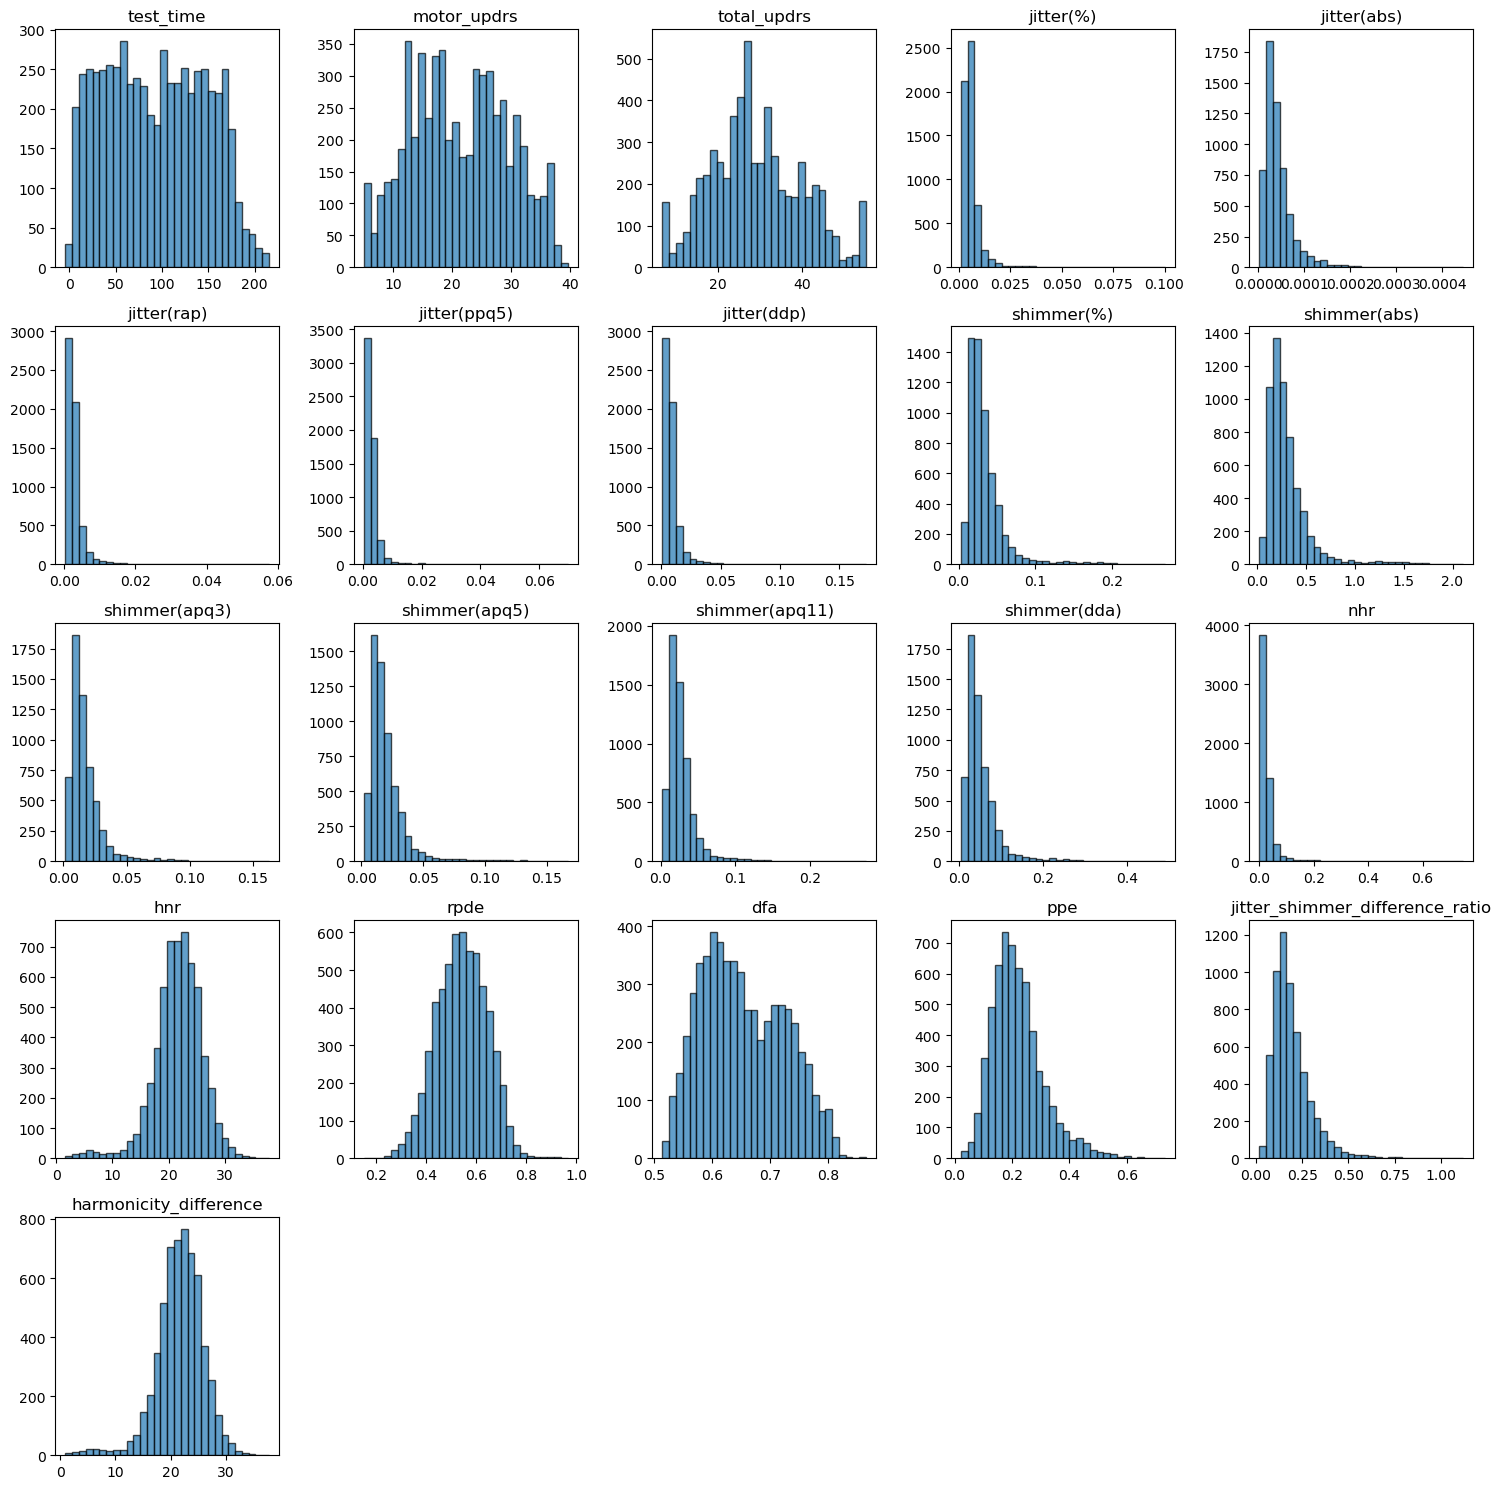

In [13]:
# Plot histograms for sample
plot_hist(sample)

Most data sets aren't shaped like a normal distribution. But we shouldn't just depend on histograms to figure this out; it's important to run a normality test as well.

In [14]:
# Function to test normality
def normality_test(sample):
    # D'Agostino's K^2 test:
    for column in sample.columns:
        data = sample[column]
        k2, p = st.normaltest(data)

        print('Column:', column)
        print('k2 =', k2)
        print('p =', p)

        # If p < 0.05, conclude that the data does not follow a normal distribution
        if p < 0.05:
            print('Data is not normally distributed.\n')
        else:
            print('Data is normally distributed.\n')

In [15]:
# Check if data of sample is normally distributed
normality_test(sample)

Column: subject#
k2 = 8481.95544027343
p = 0.0
Data is not normally distributed.

Column: age
k2 = 195.9815868869838
p = 2.77420870518974e-43
Data is not normally distributed.

Column: sex
k2 = 64677.64949042527
p = 0.0
Data is not normally distributed.

Column: test_time
k2 = 3297.403259669832
p = 0.0
Data is not normally distributed.

Column: motor_updrs
k2 = 971.3619853877516
p = 1.1787586908406643e-211
Data is not normally distributed.

Column: total_updrs
k2 = 115.7591182452
p = 7.298386492105016e-26
Data is not normally distributed.

Column: jitter(%)
k2 = 7134.412683965
p = 0.0
Data is not normally distributed.

Column: jitter(abs)
k2 = 4275.796862281011
p = 0.0
Data is not normally distributed.

Column: jitter(rap)
k2 = 7479.6358529419085
p = 0.0
Data is not normally distributed.

Column: jitter(ppq5)
k2 = 7830.048075133174
p = 0.0
Data is not normally distributed.

Column: jitter(ddp)
k2 = 7479.589099766148
p = 0.0
Data is not normally distributed.

Column: shimmer(%)
k2 = 419

We recognize that our dataset of 42 samples does not follow a normal distribution, which is usually a basic requirement for using a t-test. However, we're using this method to keep things similar to a lot of research in this area that have mainly used t-statistics. Readers should note that this violation of assumptions may impact the accuracy of our results, and therefore interpret findings with caution.

### Inferential statistics

Given the substantial size of our data 42, which is large enough (>30), z* should be used. But, because the population variance is unknown, it is more appropriate to use the t-statistic (t*).

In [16]:
# Function to calculate confidence interval of data from each column in a sample
def confidence_interval(samp):
    samp = samp.drop(['subject#', 'sex'], axis=1)
    # Iterate over each column in the DataFrame
    for i in range(0, len(samp.columns)):
        # Select the current column
        sample = samp.iloc[:, i]
        column_name = samp.columns[i]  # Get column name

        # Sample mean, standard deviation, and sample size
        x_bar = sample.mean()
        s = sample.std()
        n = sample.shape[0]

        # Standard error
        std_err = s / math.sqrt(n)

        # Confidence level, significance level, and degrees of freedom
        conf_lvl = 0.95  # we choose confidence level = 0.95
        sig_lvl = 1 - conf_lvl
        df = n - 1

        # Confidence interval with t-distribution
        ci_low_t, ci_upp_t = stm._tconfint_generic(x_bar, std_err, df, alpha=sig_lvl, alternative="two-sided")
        print(f"C.I. for column {column_name} (t*): {ci_low_t:.5f} to {ci_upp_t:.5f}. Interval size: {ci_upp_t - ci_low_t:.5f}.")

Confidence interval for the average value from data on people with Parkinson's Disease:

In [17]:
confidence_interval(sample)

C.I. for column age (t*): 64.57932 to 65.03056. Interval size: 0.45124.
C.I. for column test_time (t*): 91.49679 to 94.23065. Interval size: 2.73386.
C.I. for column motor_updrs (t*): 21.08831 to 21.50414. Interval size: 0.41583.
C.I. for column total_updrs (t*): 28.74527 to 29.29261. Interval size: 0.54734.
C.I. for column jitter(%) (t*): 0.00601 to 0.00630. Interval size: 0.00029.
C.I. for column jitter(abs) (t*): 0.00004 to 0.00004. Interval size: 0.00000.
C.I. for column jitter(rap) (t*): 0.00291 to 0.00307. Interval size: 0.00016.
C.I. for column jitter(ppq5) (t*): 0.00318 to 0.00337. Interval size: 0.00019.
C.I. for column jitter(ddp) (t*): 0.00872 to 0.00920. Interval size: 0.00048.
C.I. for column shimmer(%) (t*): 0.03337 to 0.03470. Interval size: 0.00132.
C.I. for column shimmer(abs) (t*): 0.30507 to 0.31685. Interval size: 0.01178.
C.I. for column shimmer(apq3) (t*): 0.01682 to 0.01749. Interval size: 0.00068.
C.I. for column shimmer(apq5) (t*): 0.01972 to 0.02057. Interval 

### Exploratory Data Analysis

#### Compare values of 'motor_updrs' và 'total_updrs' among groups based on 'age' and 'sex'

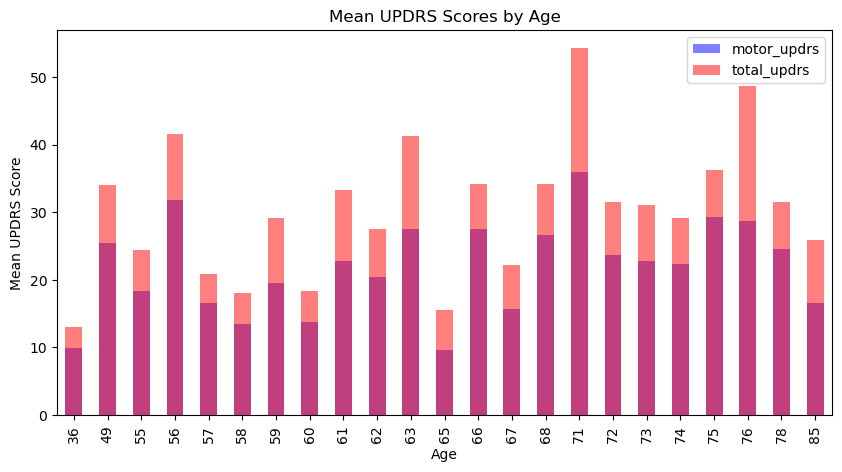

Overall, total UPDRS is bigger than motor UPDRS for all ages.


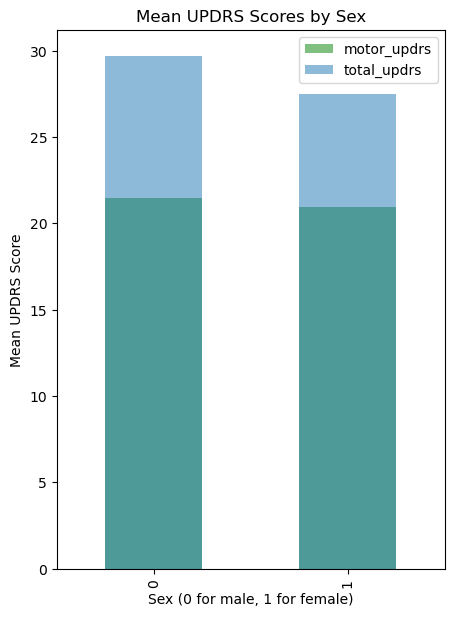

total UPDRS is bigger than motor UPDRS for all sexes but there's no difference between the genders.


In [18]:
# Analysis based on age ('age')
grouped_by_age = sample.groupby('age')[['motor_updrs', 'total_updrs']].mean()

# Plotting the graph
plt.figure(figsize=(10, 5))
grouped_by_age['motor_updrs'].plot(kind='bar', alpha=0.5, color='blue', label='motor_updrs')
grouped_by_age['total_updrs'].plot(kind='bar', alpha=0.5, color='red', label='total_updrs')
plt.title('Mean UPDRS Scores by Age')
plt.xlabel('Age')
plt.ylabel('Mean UPDRS Score')
plt.legend()
plt.show()
print("Overall, total UPDRS is bigger than motor UPDRS for all ages.")

# Analysis based on gender ('sex')
grouped_by_sex = sample.groupby('sex')[['motor_updrs', 'total_updrs']].mean()

# Plotting the graph
plt.figure(figsize=(5, 7))
grouped_by_sex['motor_updrs'].plot(kind='bar', alpha=0.5, color='green', label='motor_updrs')
grouped_by_sex['total_updrs'].plot(kind='bar', alpha=0.5, label='total_updrs')
plt.title('Mean UPDRS Scores by Sex')
plt.xlabel('Sex (0 for male, 1 for female)')
plt.ylabel('Mean UPDRS Score')
plt.legend()
plt.show()
print("total UPDRS is bigger than motor UPDRS for all sexes but there's no difference between the genders.")

#### Distribution of categorical variables

Number of Records for Each Subject

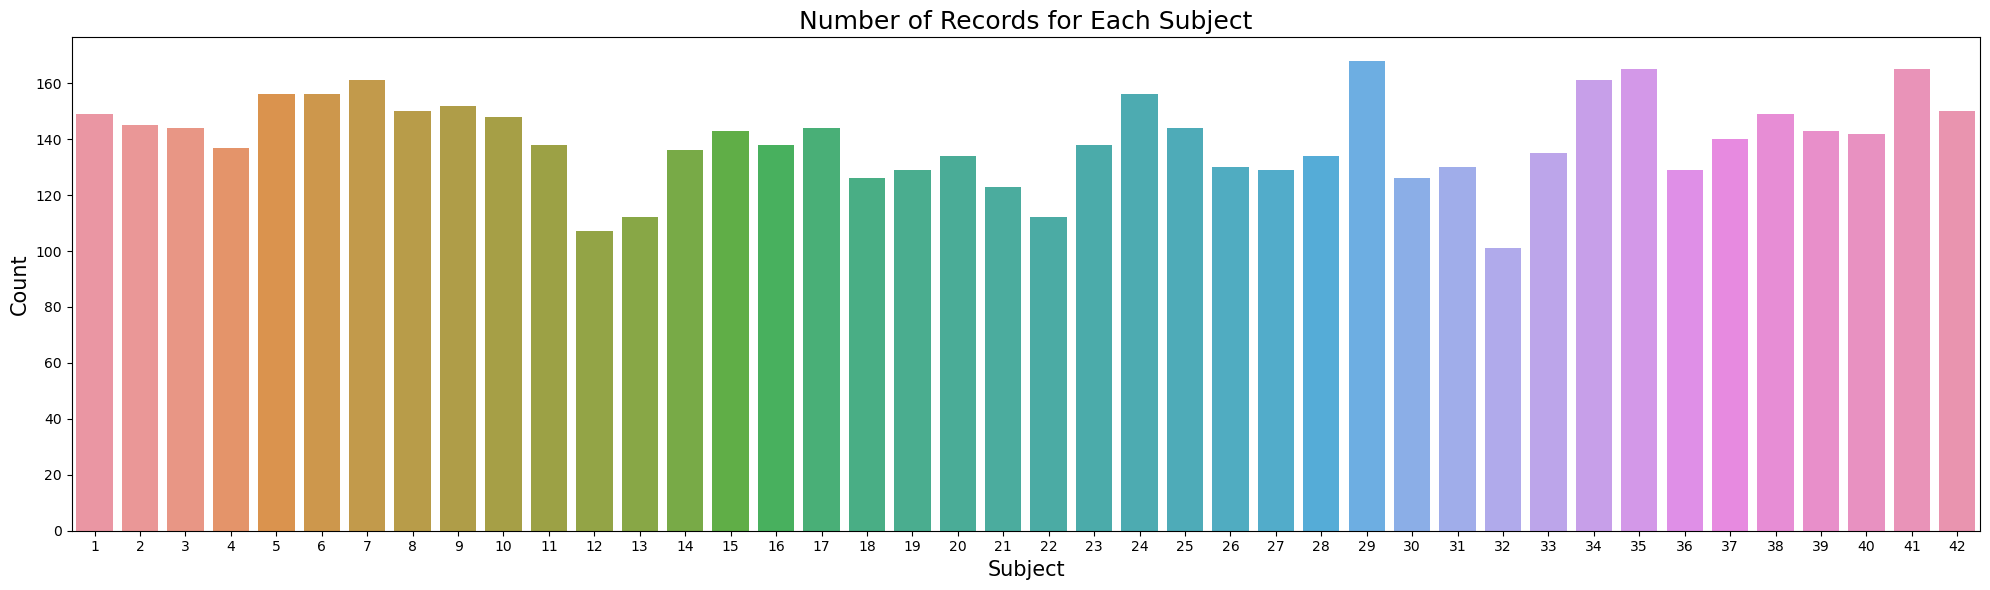

In [19]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Plot number of records for each 'subject#'
sns.countplot(data=sample, x='subject#')
plt.title('Number of Records for Each Subject', fontsize=18)
plt.xlabel('Subject', fontsize=15)
plt.ylabel('Count', fontsize=15)
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Each subject has a number of voice samples ranging from 100 to over 160. The gap between the number of samples for each subject is not too large.

Distribution of 'sex'

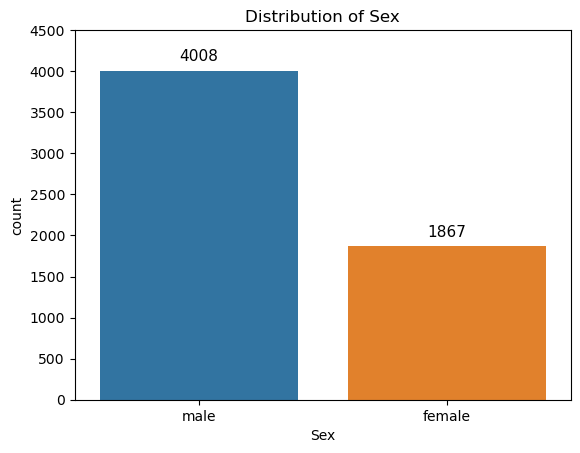

In [20]:
# For categorical variables like 'sex'
ax = sns.countplot(data=sample, x='sex')
plt.title('Distribution of Sex')
plt.xlabel('Sex')
# Rename the ticks on the x-axis
ax.set_xticks([0, 1])
ax.set_ylim(0, 4500)
ax.set_xticklabels(['male', 'female'])
# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')
plt.show()

The number of samples from males is roughly doubled that of females.

#### Distribution of key continuous variables

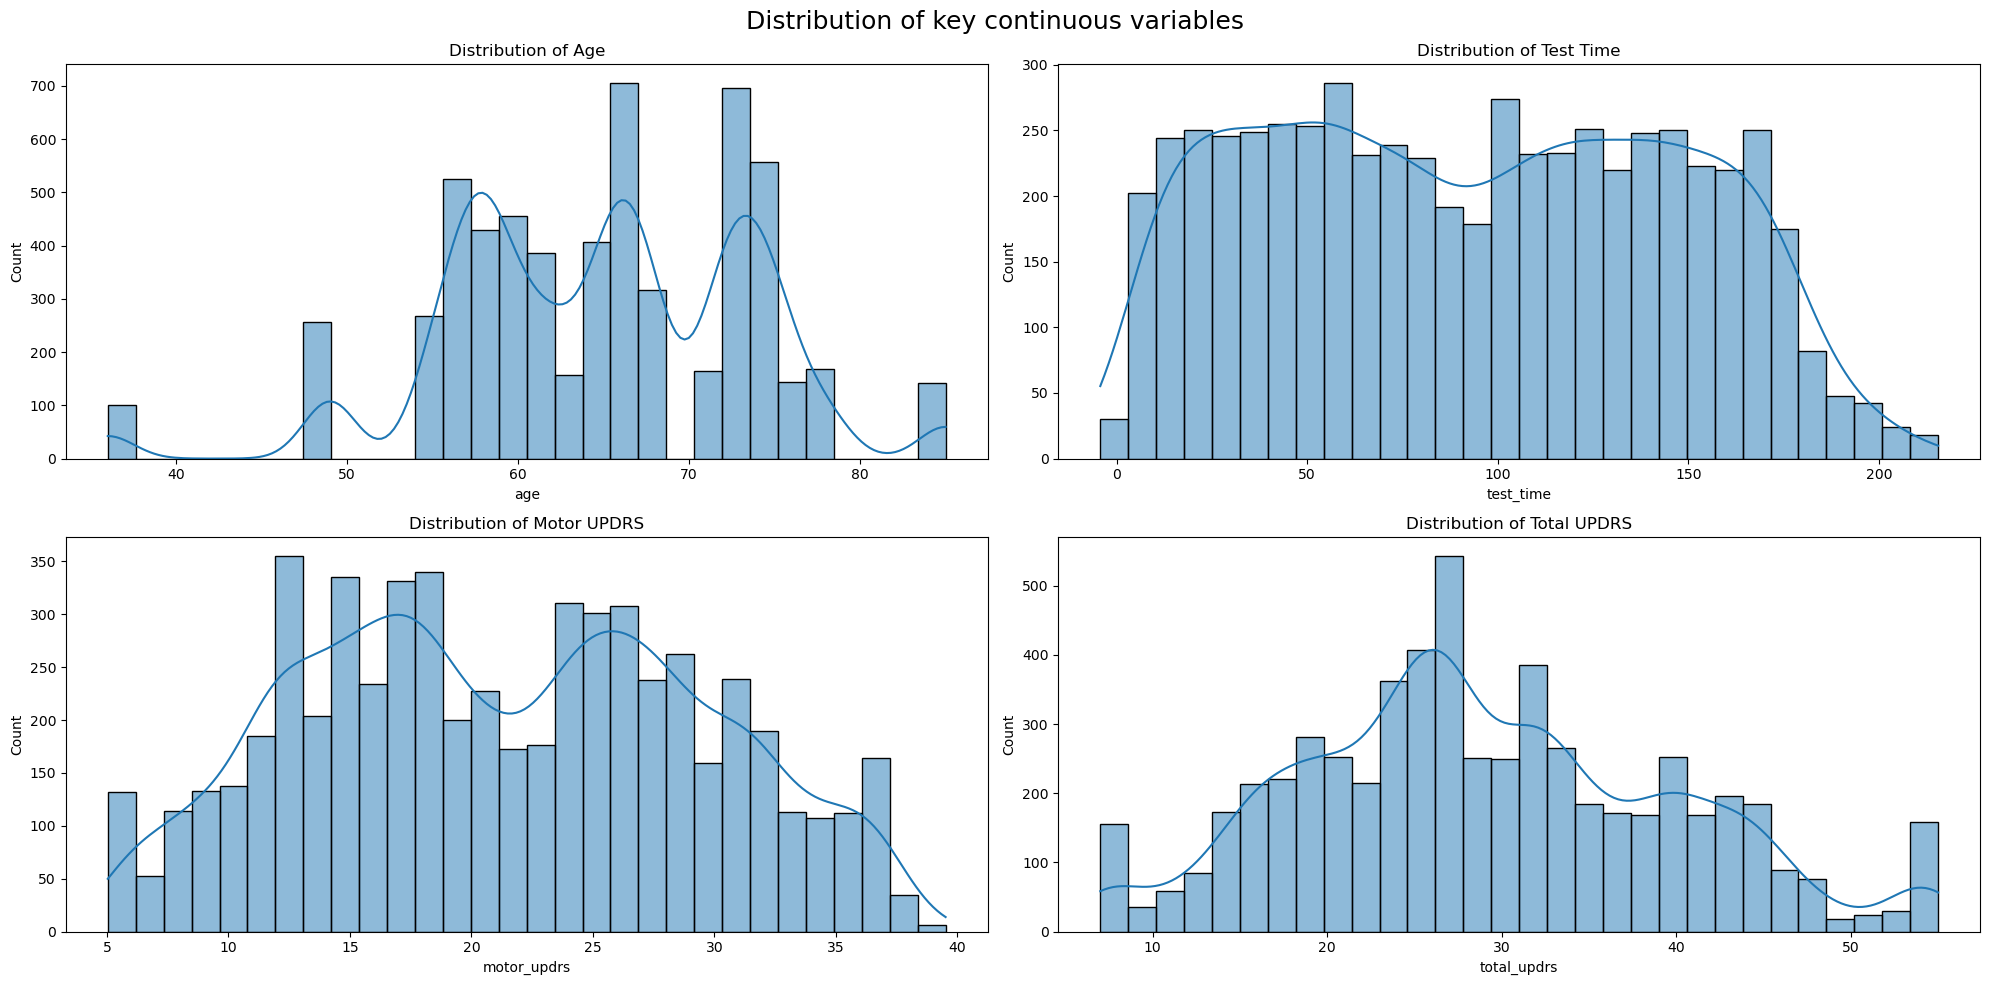

In [21]:
# Distribution of key continuous variables
plt.figure(figsize=(20, 10))

# Plot distribution of 'age'
plt.subplot(2, 2, 1)
sns.histplot(data=sample, x='age', bins=30, kde=True)
plt.title('Distribution of Age')

# Plot distribution of 'test_time'
plt.subplot(2, 2, 2)
sns.histplot(data=sample, x='test_time', bins=30, kde=True)
plt.title('Distribution of Test Time')

# Plot distribution of 'motor_updrs'
plt.subplot(2, 2, 3)
sns.histplot(data=sample, x='motor_updrs', bins=30, kde=True)
plt.title('Distribution of Motor UPDRS')

# Plot distribution of 'total_updrs'
plt.subplot(2, 2, 4)
sns.histplot(data=sample, x='total_updrs', bins=30, kde=True)
plt.title('Distribution of Total UPDRS')

plt.suptitle('Distribution of key continuous variables', fontsize=18)
plt.tight_layout()
plt.show()

From the visualizations of the key continuous variables:
- Distribution of Age: The age distribution seems somewhat uniform, with slight peaks around 55 and 75 years.
- Distribution of Test Time: Test time seems to have a relatively uniform distribution, but with notable peaks around 40, 95, and 150 minutes.
- Distribution of Motor UPDRS: The motor UPDRS scores have a somewhat left-skewed distribution with a peak around the 20-25 score range.
- Distribution of Total UPDRS: The total UPDRS scores show a peak around the 20-30 score range and then gradually decrease.

#### Check UPDRS Scores by Gender

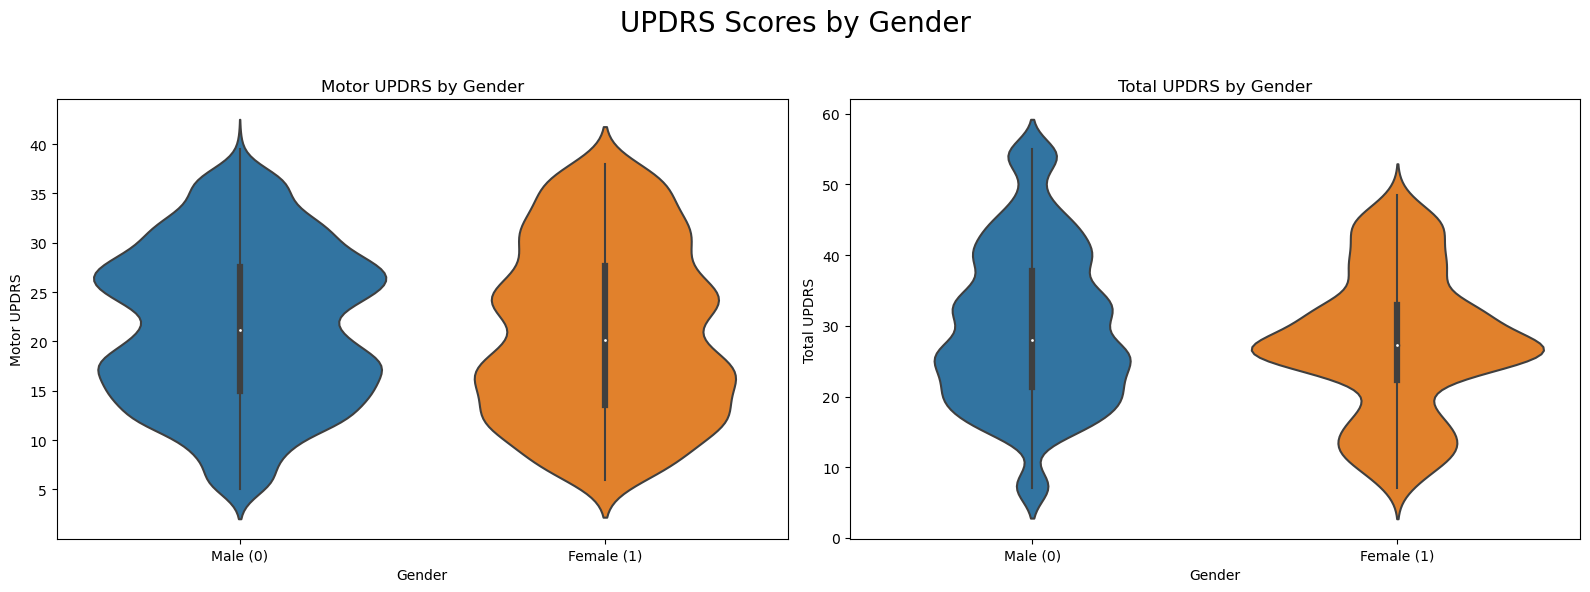

In [22]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Main Title
fig.suptitle('UPDRS Scores by Gender', fontsize=20)

# Boxplot for motor_updrs by gender
sns.violinplot(x='sex', y='motor_updrs', data=sample, ax=axes[0])
axes[0].set_title('Motor UPDRS by Gender')
axes[0].set_ylabel('Motor UPDRS')
axes[0].set_xlabel('Gender')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Male (0)', 'Female (1)'])

# Boxplot for total_updrs by gender
sns.violinplot(x='sex', y='total_updrs', data=sample, ax=axes[1])
axes[1].set_title('Total UPDRS by Gender')
axes[1].set_ylabel('Total UPDRS')
axes[1].set_xlabel('Gender')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Male (0)', 'Female (1)'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

For Motor UPDRS, there's no difference between male and female, while Total UPDRS of male has big range compared to that of female.

#### Check UPDRS Scores by Age

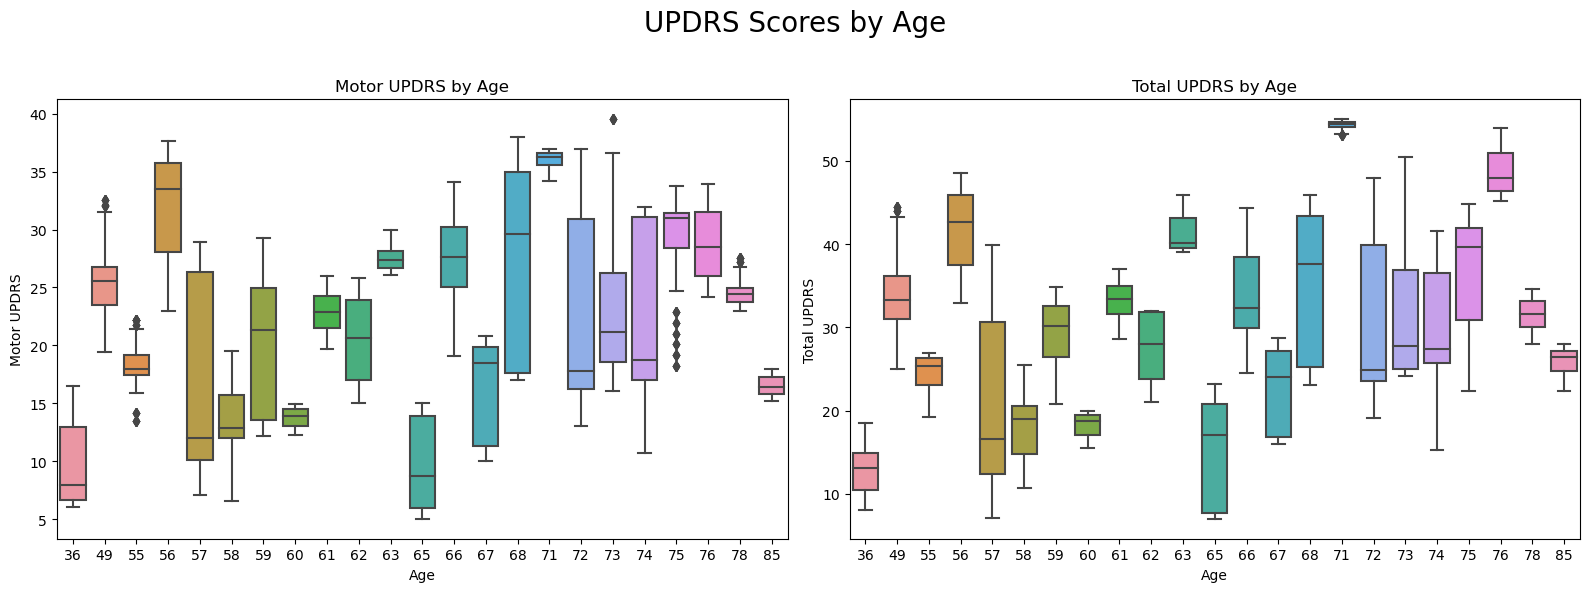

In [23]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Main Title
fig.suptitle('UPDRS Scores by Age', fontsize=20)

# Boxplot for motor_updrs by age
sns.boxplot(x='age', y='motor_updrs', data=sample, ax=axes[0])
axes[0].set_title('Motor UPDRS by Age')
axes[0].set_ylabel('Motor UPDRS')
axes[0].set_xlabel('Age')

# Boxplot for total_updrs by age
sns.boxplot(x='age', y='total_updrs', data=sample, ax=axes[1])
axes[1].set_title('Total UPDRS by Age')
axes[1].set_ylabel('Total UPDRS')
axes[1].set_xlabel('Age')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the main title
plt.show()

There's no clear relationships between age and UPDRS scores.

#### Check UPDRS Scores by Sex

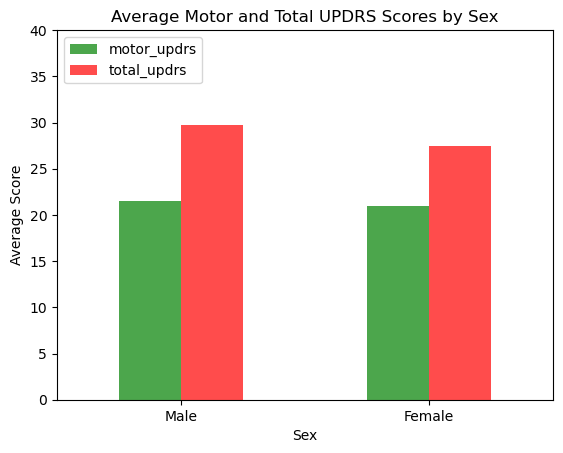

In [24]:
# Calculate the mean 'motor_updrs' and 'total_updrs' for each 'sex'
grouped = sample.groupby('sex').mean()[['motor_updrs', 'total_updrs']]

# Rename the index
grouped.index = ['Male', 'Female']

# Define colors
colors = ['green', 'red']

# Draw the plot
ax = grouped.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Average Motor and Total UPDRS Scores by Sex')
plt.xlabel('Sex')
plt.ylabel('Average Score')

# Set the maximum number of ticks on y-axis (optional)
plt.yticks(np.linspace(0, 40, 9))

# Set xtick labels to be horizontal
ax.set_xticklabels(grouped.index, rotation=0)

plt.legend(loc='upper left')
plt.show()

Looking at the bar chart above, it's clear that there's no significant difference between men and women in terms of their motor_UPDRS and total_UPDRS scores. Generally, total UPDRS is bigger than motor UPDRS for both male and female.

#### Draw scatter plot to check the relationships between features and UPDRS scores

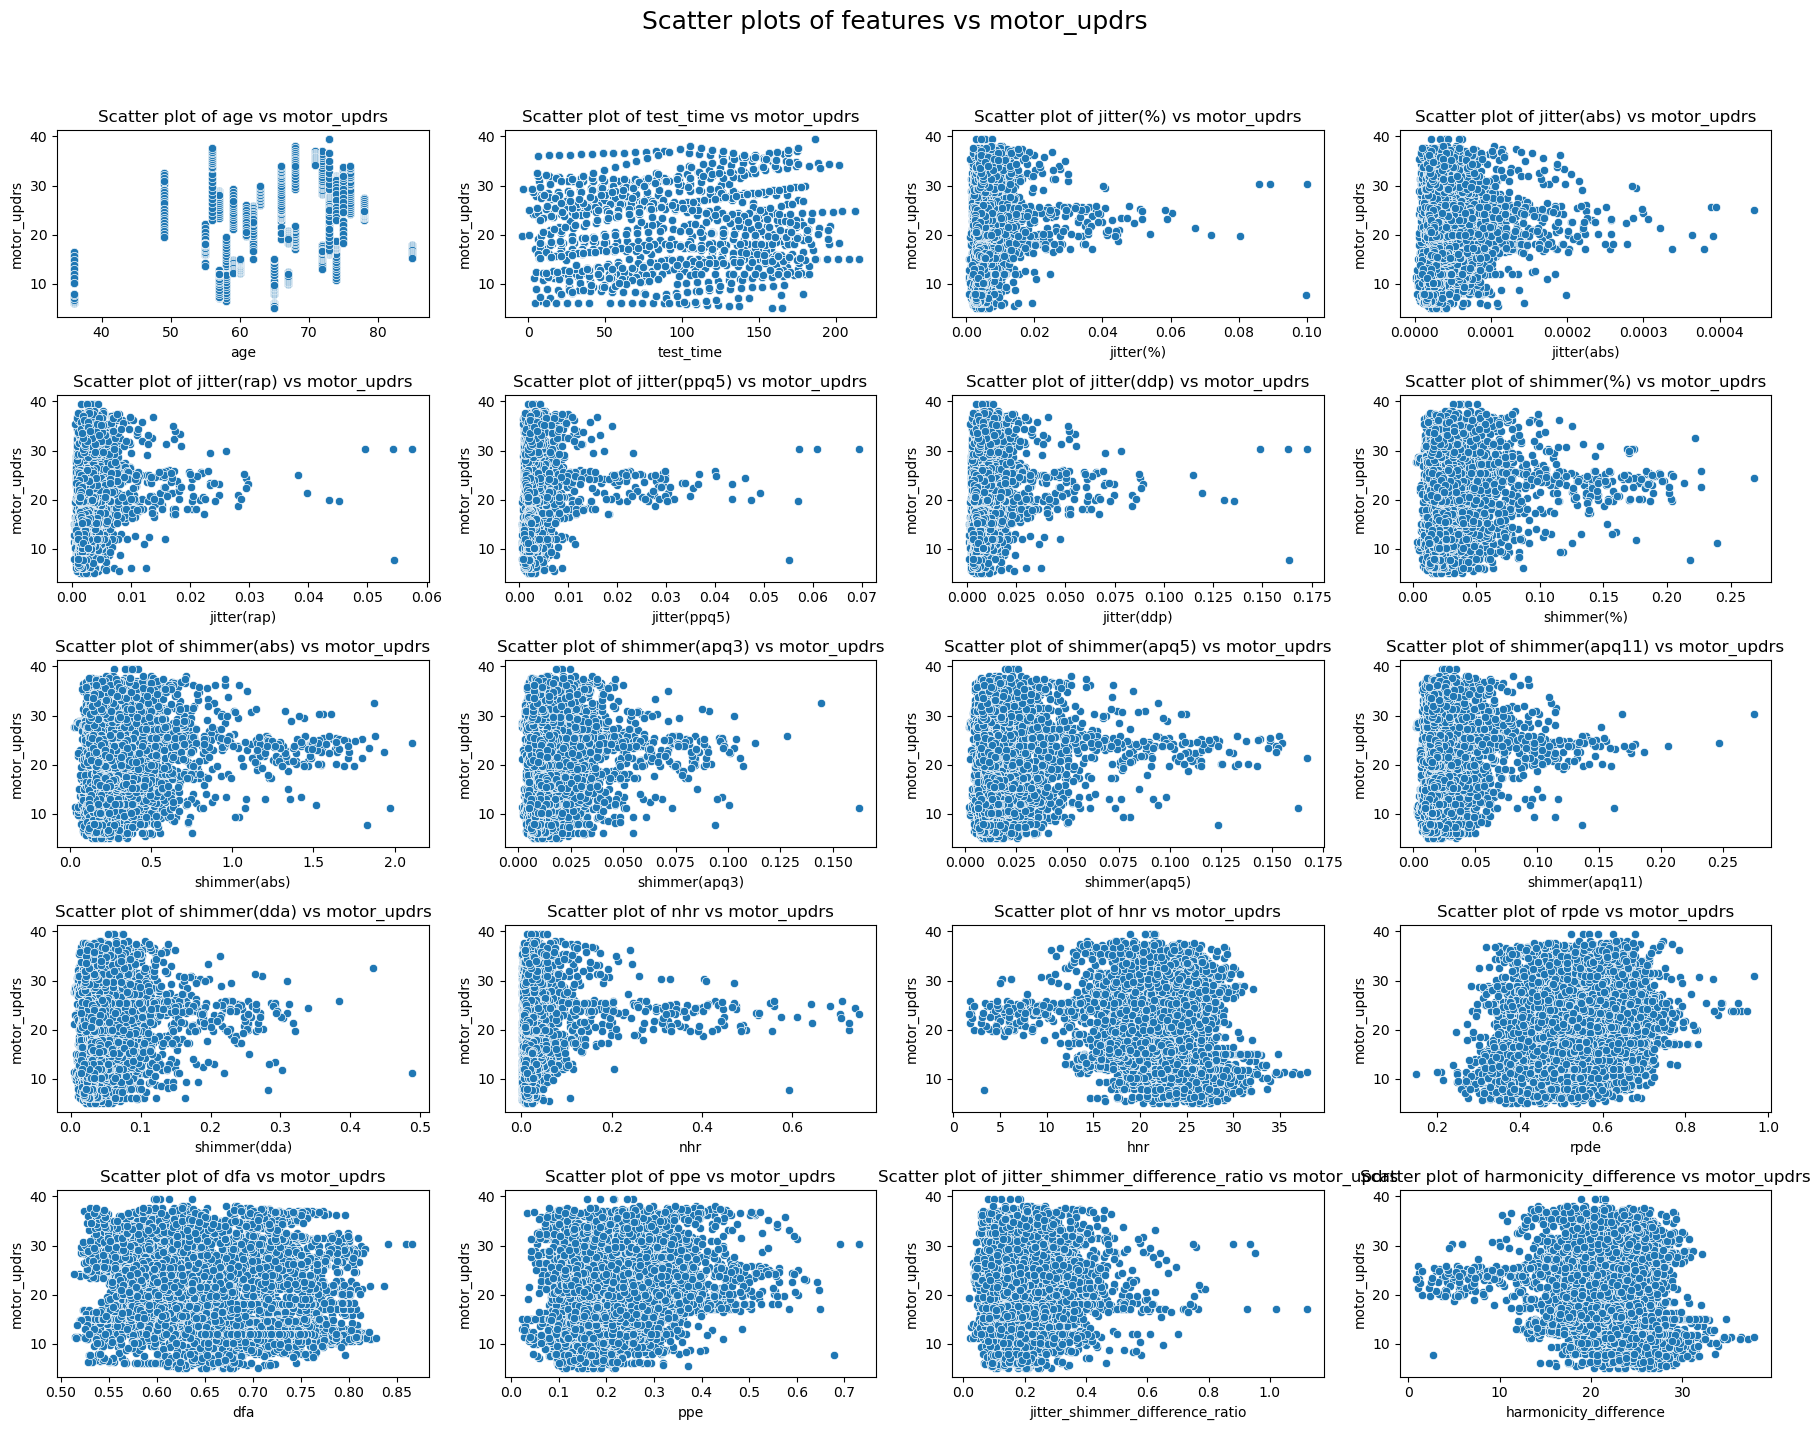

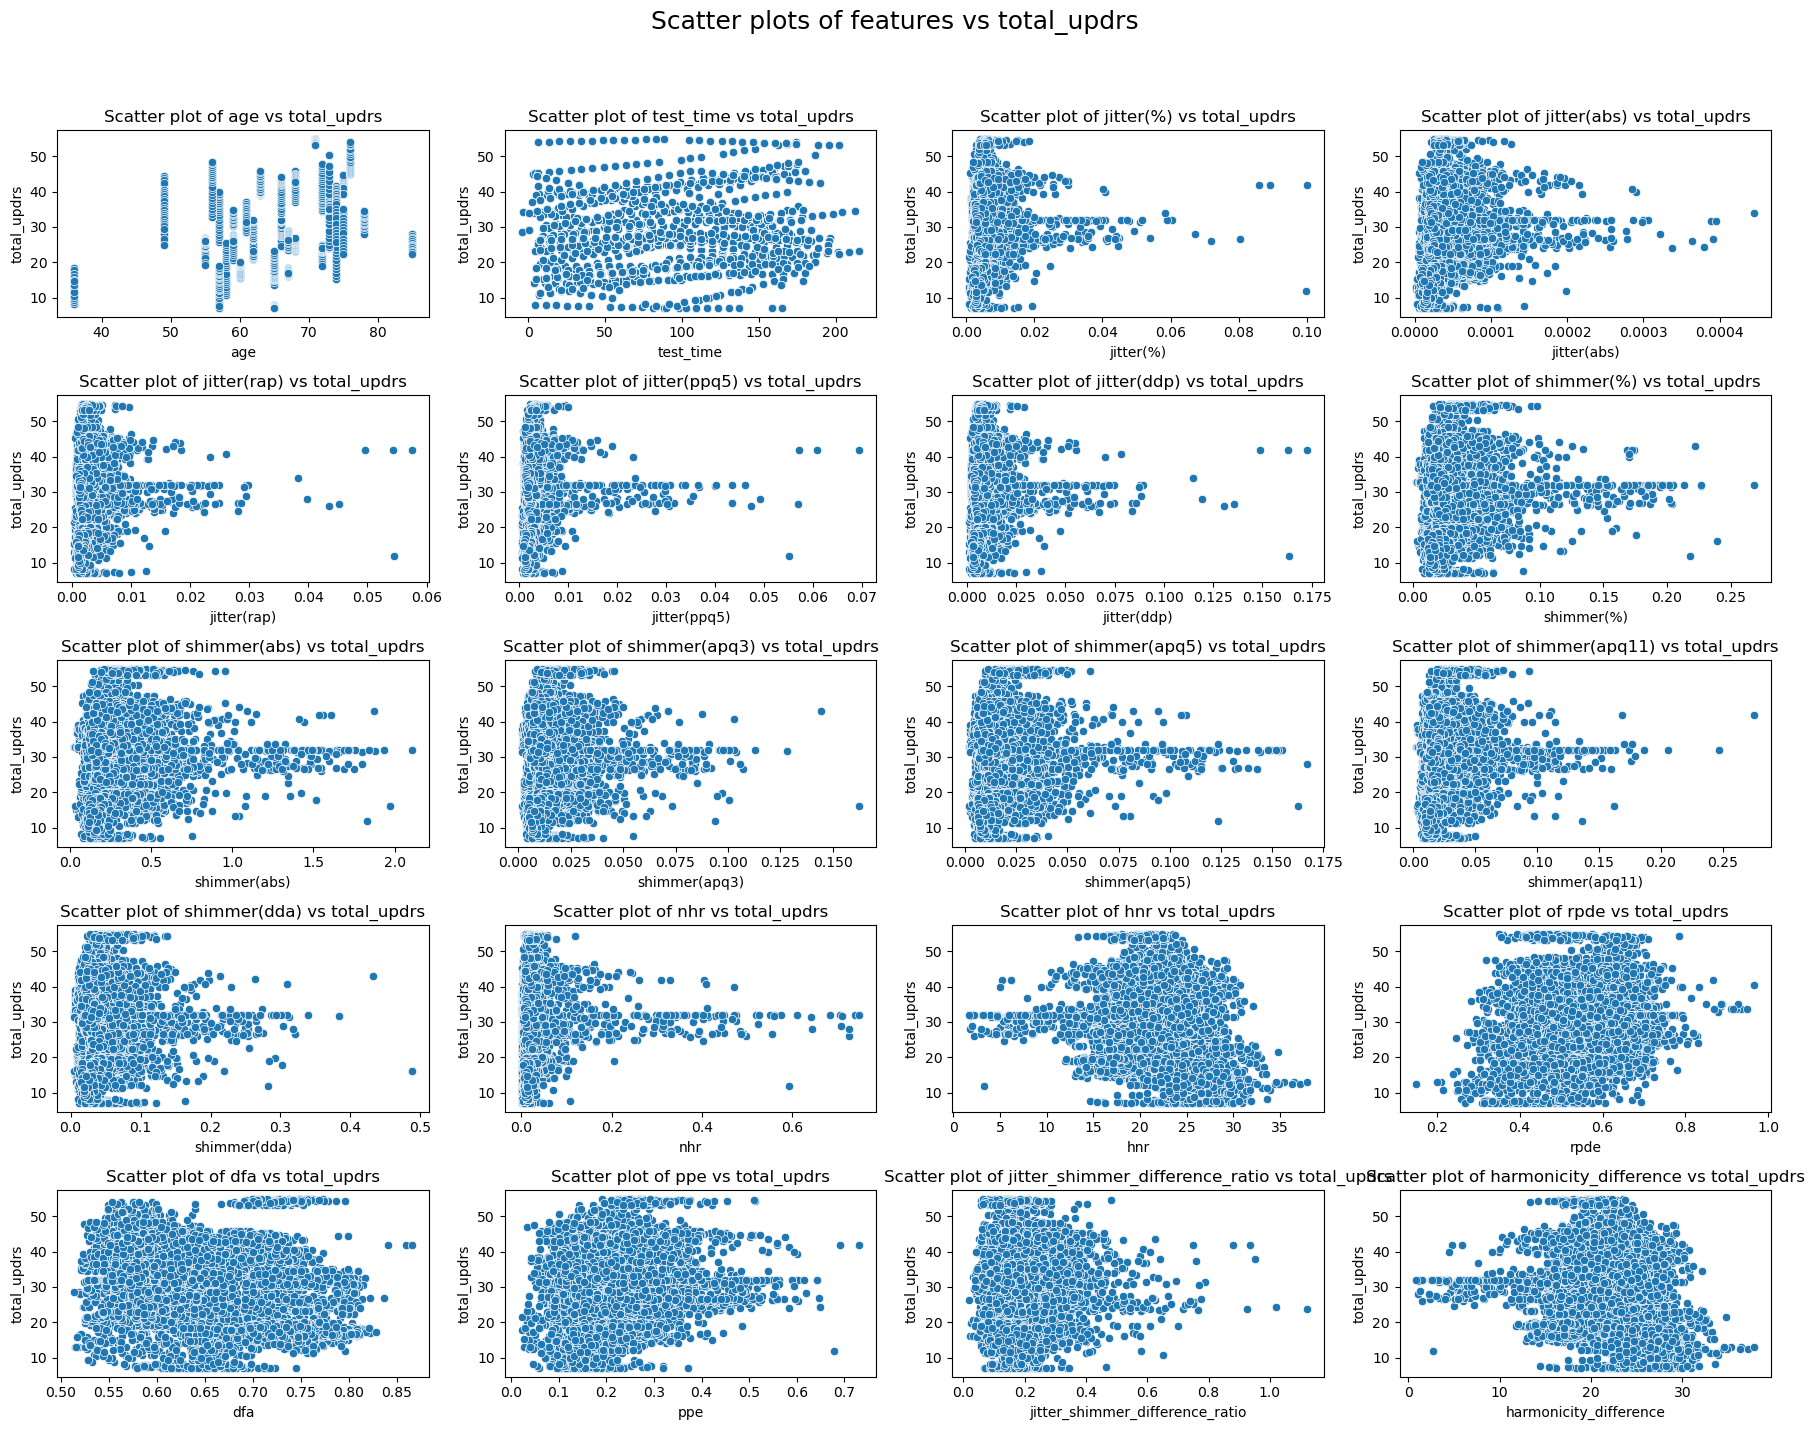

In [25]:
# List of independent variables
independent_features = ['age', 'test_time', 'jitter(%)', 'jitter(abs)', 'jitter(rap)', 'jitter(ppq5)', 'jitter(ddp)',
                  'shimmer(%)', 'shimmer(abs)', 'shimmer(apq3)', 'shimmer(apq5)',
                  'shimmer(apq11)', 'shimmer(dda)', 'nhr', 'hnr', 'rpde', 'dfa',
                  'ppe', 'jitter_shimmer_difference_ratio', 'harmonicity_difference']

# List of dependent variables
cols_to_display = ['motor_updrs', 'total_updrs']

# Plot scatter plots for each independent variable against the dependent variables
for target in cols_to_display:
    plt.figure(figsize=(18, 15))
    for i, feature in enumerate(independent_features, 1):
        plt.subplot(5, 4, i)
        sns.scatterplot(data=sample, x=feature, y=target)
        plt.title(f"Scatter plot of {feature} vs {target}")

    plt.suptitle(f"Scatter plots of features vs {target}", fontsize=18)  # Setting the main title for the whole figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### The relationship between UPDRS scores and the time when patients take the test

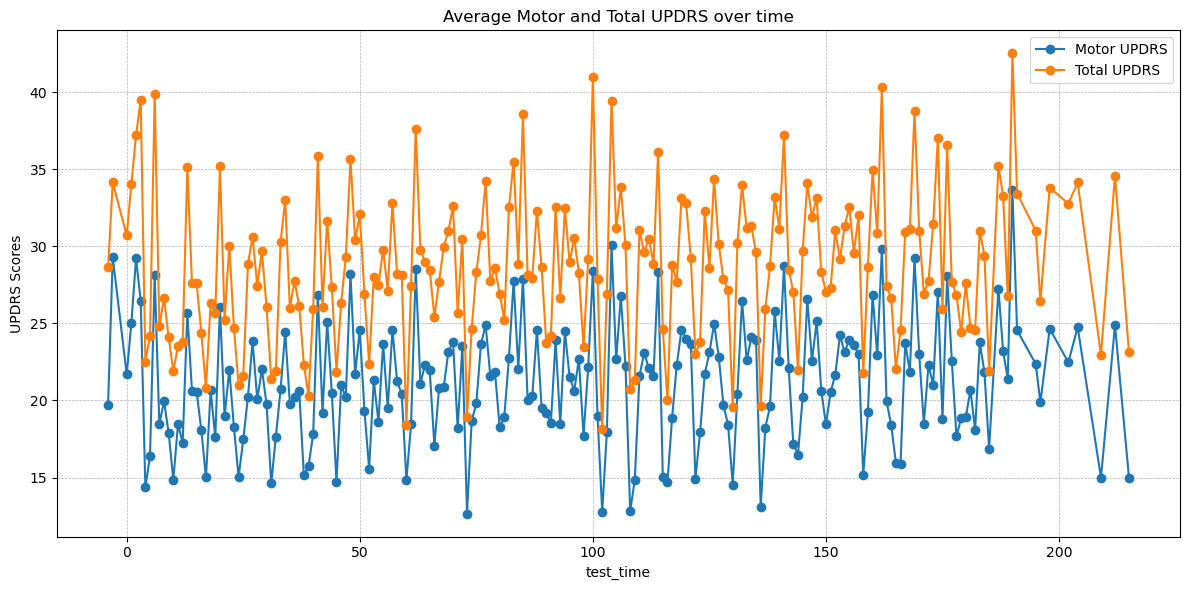

In [26]:
# Replace 'test_time' values by rounding test_time values
new_df = df
new_df['test_time'] = new_df['test_time'].round()

# Calculate average values grouped by test_time
average_values = new_df.groupby('test_time')[['motor_updrs', 'total_updrs']].mean()

plt.figure(figsize=(12, 6))

# Draw Line charts for motor_updrs and total_updrs
plt.plot(average_values.index, average_values['motor_updrs'], label='Motor UPDRS', marker='o')
plt.plot(average_values.index, average_values['total_updrs'], label='Total UPDRS', marker='o')

plt.title('Average Motor and Total UPDRS over time')
plt.xlabel('test_time')
plt.ylabel('UPDRS Scores')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

The line graph above show that UPDRS scores fluctuate during the recored time. There's no relationship between test_time and UPDRS scores in general.

Draw line charts showing how UPDRS scores change over time for each subject

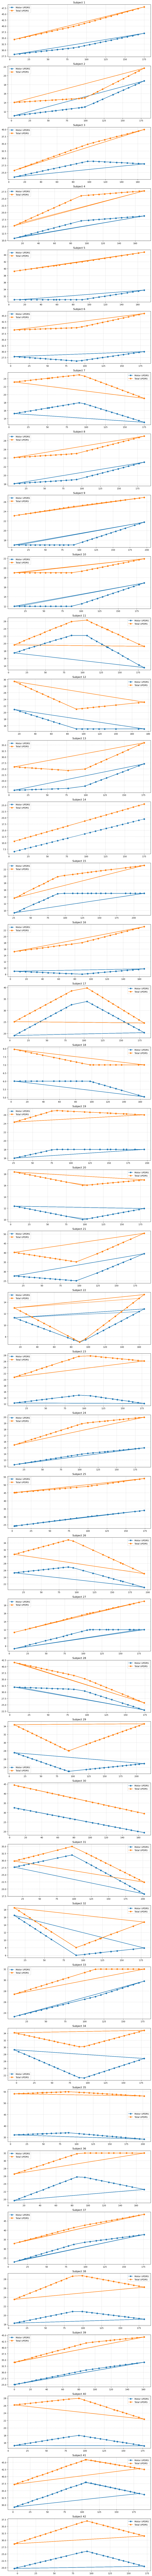

In [27]:
subjects = new_df['subject#'].unique()

# Set up sizes for line charts
fig, axes = plt.subplots(nrows=len(subjects), ncols=1, figsize=(10, 4 * len(subjects)))

for idx, subject in enumerate(subjects):
    subject_data = new_df[new_df['subject#'] == subject]

    axes[idx].plot(subject_data['test_time'], subject_data['motor_updrs'], label='Motor UPDRS', marker='o')
    axes[idx].plot(subject_data['test_time'], subject_data['total_updrs'], label='Total UPDRS', marker='o')
    axes[idx].set_title(f'Subject {subject}')
    axes[idx].legend()
    axes[idx].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In these line graphs, it can be seen that most patients have UPRDS incresed linearly over time, while some other patients have these scores dropping over time. Additionally, there are a few cases where UPRDS scores go up then go down during the testing period of time.

 #### Correlation heatmap for all variables with motor_updrs and total_updrs

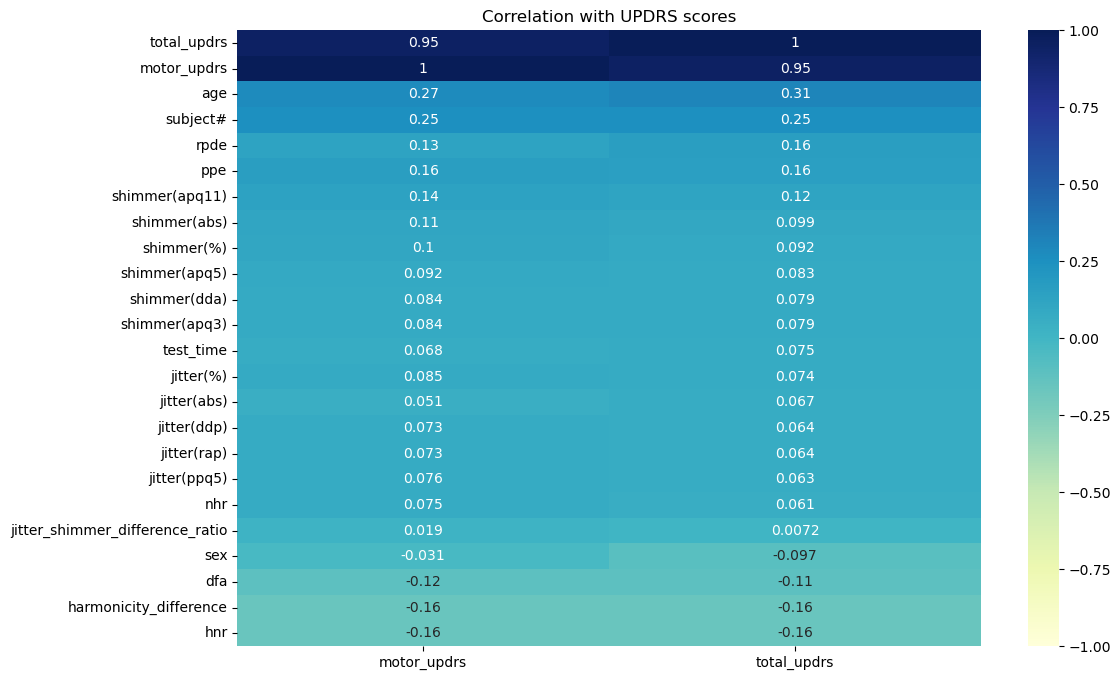

In [28]:
# Compute the correlation matrix
correlation_matrix = sample.corr()

# Select columns to be displayed
cols_to_display = ['motor_updrs', 'total_updrs']

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[cols_to_display].sort_values(by='total_updrs', ascending=False), annot=True, cmap="YlGnBu", vmin=-1, vmax=1)
plt.title("Correlation with UPDRS scores")
plt.show()

We have some comments for the correlation heatmap above (exclude 'subject#'):
- motor_updrs and total_updrs have a significant correlation, as expected.
- The top 5 variables with the highest absolute correlation to 'motor_updrs' are: age, ppe, hnr, harmonicity_difference, shimmer(apq11).
- The top 5 variables with the highest absolute correlation to 'total_updrs' are: age, hnr, harmonicity_difference, rpde, ppe.

 #### Correlation heatmap for all voice features

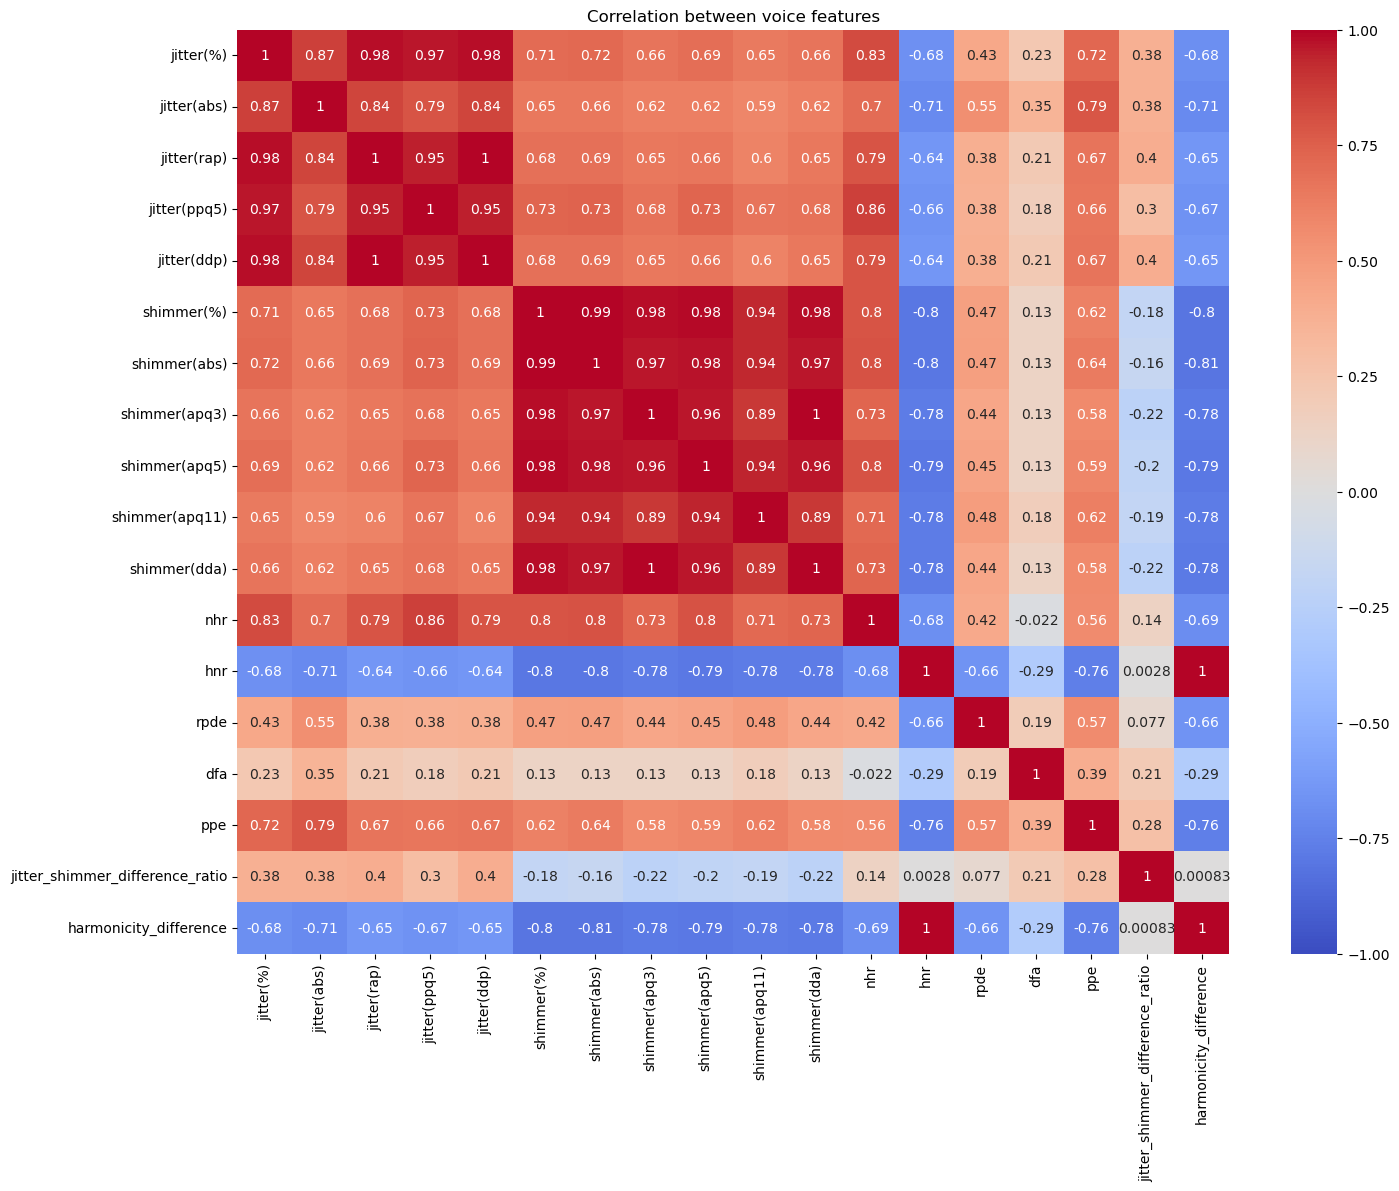

In [29]:
def correlation_heatmap():
    # List of voice features to be considered
    voice_features = ['jitter(%)', 'jitter(abs)', 'jitter(rap)', 'jitter(ppq5)', 'jitter(ddp)', 'shimmer(%)', 'shimmer(abs)', 'shimmer(apq3)', 'shimmer(apq5)', 'shimmer(apq11)', 'shimmer(dda)', 'nhr', 'hnr', 'rpde', 'dfa', 'ppe', 'jitter_shimmer_difference_ratio', 'harmonicity_difference']

    # Compute the correlation matrix just for the voice features
    voice_correlation = df[voice_features].corr()

    # Plot heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(voice_correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation between voice features")
    plt.show()

correlation_heatmap()

Correlation values range between -1 and 1. A value closer to 1 implies a strong positive correlation: as one variable increases, the other also tends to. A value closer to -1 implies a strong negative correlation: as one variable increases, the other tends to decrease. A value closer to 0 implies weak correlation: changes in one variable do not predict changes in another variable.

- From the heatmap above, many voice-related features like jitter and shimmer attributes have strong correlations with each other.
- The voice-related features, such as jitter, shimmer, and nhr, tend to have negative correlations with hnr.
- Additionally, harmonicity_difference and hnr also exhibit a strong linear relationship, with a correlation coefficient of 1.

## Building predictive models

#### Baseline model: Use median of target variables for training (instead of mean to avoid the influence of outliers)

In [30]:
# Splitting the data into train and test sets (60-40)
features = sample.drop(columns=['motor_updrs', 'total_updrs', 'subject#'])
target_motor = sample['motor_updrs']
target_total = sample['total_updrs']

X_train_motor, X_test_motor, y_train_motor, y_test_motor = train_test_split(features, target_motor, test_size=0.4, random_state=42)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(features, target_total, test_size=0.4, random_state=42)

# Initialize metrics dictionary for 'motor_updrs' and 'total_updrs'
metrics_motor_baseline = {
    'Model': ['Baseline'],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'Normalized RMSE': [],
    'R-square': []
}

metrics_total_baseline = {
    'Model': ['Baseline'],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'Normalized RMSE': [],
    'R-square': []
}

# Predict using median value for 'motor_updrs'
median_motor = y_train_motor.median()
predictions_motor_baseline = [median_motor] * len(y_test_motor)

# Calculate metrics for 'motor_updrs' baseline model
mae_motor = mean_absolute_error(y_test_motor, predictions_motor_baseline)
mse_motor = mean_squared_error(y_test_motor, predictions_motor_baseline)
rmse_motor = np.sqrt(mse_motor)
normalized_rmse_motor = rmse_motor / (y_test_motor.max() - y_test_motor.min())
r2_motor = r2_score(y_test_motor, predictions_motor_baseline)

# Store the metrics for 'motor_updrs'
metrics_motor_baseline['MAE'].append(mae_motor)
metrics_motor_baseline['MSE'].append(mse_motor)
metrics_motor_baseline['RMSE'].append(rmse_motor)
metrics_motor_baseline['Normalized RMSE'].append(normalized_rmse_motor)
metrics_motor_baseline['R-square'].append(r2_motor)

# Predict using median value for 'total_updrs'
median_total = y_train_total.median()
predictions_total_baseline = [median_total] * len(y_test_total)

# Calculate metrics for 'total_updrs' baseline model
mae_total = mean_absolute_error(y_test_total, predictions_total_baseline)
mse_total = mean_squared_error(y_test_total, predictions_total_baseline)
rmse_total = np.sqrt(mse_total)
normalized_rmse_total = rmse_total / (y_test_total.max() - y_test_total.min())
r2_total = r2_score(y_test_total, predictions_total_baseline)

# Store the metrics for 'total_updrs'
metrics_total_baseline['MAE'].append(mae_total)
metrics_total_baseline['MSE'].append(mse_total)
metrics_total_baseline['RMSE'].append(rmse_total)
metrics_total_baseline['Normalized RMSE'].append(normalized_rmse_total)
metrics_total_baseline['R-square'].append(r2_total)

# Convert metrics to DataFrames and display
df_metrics_motor_baseline = pd.DataFrame(metrics_motor_baseline)
df_metrics_total_baseline = pd.DataFrame(metrics_total_baseline)

In [31]:
df_metrics_motor_baseline

Model       MAE        MSE      RMSE  Normalized RMSE  R-square
0  Baseline  6.814167  64.324041  8.020227          0.23265 -0.005802

In [32]:
df_metrics_total_baseline

Model       MAE         MSE      RMSE  Normalized RMSE  R-square
0  Baseline  8.377706  112.576772  10.61022         0.221083 -0.020182

### Simple linear regression model

In [33]:
# Calculate the correlation matrix
corr_matrix = sample.corr()

# Get the top 5 variables (excluding 'subject') for 'motor_updrs' and 'total_updrs'
top_5_motor = corr_matrix['motor_updrs'].drop(['subject#', 'motor_updrs', 'total_updrs']).abs().nlargest(5).index.tolist()
top_5_total = corr_matrix['total_updrs'].drop(['subject#', 'motor_updrs', 'total_updrs']).abs().nlargest(5).index.tolist()

top_5_motor, top_5_total

(['age', 'ppe', 'hnr', 'harmonicity_difference', 'shimmer(apq11)'],
 ['age', 'hnr', 'harmonicity_difference', 'rpde', 'ppe'])

Simple linear regression model for 'motor_updrs'

In [34]:
# Split the dataset into training and testing sets
X_train, X_test, y_train_motor, y_test_motor = train_test_split(
    sample[top_5_motor], sample['motor_updrs'], test_size=0.4, random_state=42)

# Initialize metrics dictionary for 'motor_updrs'
metrics_motor = {
    'Variable': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'Normalized RMSE': [],
    'R-square': []
}

# Build simple linear regression models and calculate metrics for 'motor_updrs'
for variable in top_5_motor:
    # Train the model
    model = LinearRegression()
    model.fit(X_train[[variable]], y_train_motor)

    # Predict on the test set
    predictions = model.predict(X_test[[variable]])

    # Calculate metrics
    mae = mean_absolute_error(y_test_motor, predictions)
    mse = mean_squared_error(y_test_motor, predictions)
    rmse = mean_squared_error(y_test_motor, predictions, squared=False)
    normalized_rmse = rmse / (y_test_motor.max() - y_test_motor.min())
    r2 = r2_score(y_test_motor, predictions)

    # Store the metrics
    metrics_motor['Variable'].append(variable)
    metrics_motor['MAE'].append(mae)
    metrics_motor['MSE'].append(mse)
    metrics_motor['RMSE'].append(rmse)
    metrics_motor['Normalized RMSE'].append(normalized_rmse)
    metrics_motor['R-square'].append(r2)

# Convert the metrics dictionary to a DataFrame for 'motor_updrs'
df_metrics_motor = pd.DataFrame(metrics_motor)

df_metrics_motor

Variable       MAE        MSE      RMSE  Normalized RMSE  \
0                     age  6.545815  58.922952  7.676129         0.222669   
1                     ppe  6.747792  62.394924  7.899046         0.229135   
2                     hnr  6.743121  62.718418  7.919496         0.229728   
3  harmonicity_difference  6.744948  62.727739  7.920085         0.229745   
4          shimmer(apq11)  6.743913  62.758897  7.922051         0.229803   

   R-square  
0  0.078652  
1  0.024362  
2  0.019304  
3  0.019158  
4  0.018671

From the table we just looked at, the best simple linear regression model for predicting 'motor_updrs' uses 'age' as its predictor. This model has a Normalized RMSE of 0.222669 and an R-squared value of 0.078652.

Simple linear regression model for 'total_updrs'

In [35]:
# Split the dataset into training and testing sets
X_train, X_test, y_train_total, y_test_total = train_test_split(
    sample[top_5_total], sample['total_updrs'], test_size=0.4, random_state=42)

# Initialize metrics dictionary for 'total_updrs'
metrics_total = {
    'Variable': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'Normalized RMSE': [],
    'R-square': []
}

# Build simple linear regression models and calculate metrics for 'total_updrs'
for variable in top_5_total:
    # Train the model
    model = LinearRegression()
    model.fit(X_train[[variable]], y_train_total)

    # Predict on the test set
    predictions = model.predict(X_test[[variable]])

    # Calculate metrics
    mae = mean_absolute_error(y_test_total, predictions)
    mse = mean_squared_error(y_test_total, predictions)
    rmse = mean_squared_error(y_test_total, predictions, squared=False)
    normalized_rmse = rmse / (y_test_total.max() - y_test_total.min())
    r2 = r2_score(y_test_total, predictions)

    # Store the metrics
    metrics_total['Variable'].append(variable)
    metrics_total['MAE'].append(mae)
    metrics_total['MSE'].append(mse)
    metrics_total['RMSE'].append(rmse)
    metrics_total['Normalized RMSE'].append(normalized_rmse)
    metrics_total['R-square'].append(r2)

# Convert the metrics dictionary to a DataFrame for 'total_updrs'
df_metrics_total = pd.DataFrame(metrics_total)

df_metrics_total

Variable       MAE         MSE       RMSE  Normalized RMSE  \
0                     age  8.252296   98.555183   9.927496         0.206857   
1                     hnr  8.428331  107.765719  10.381027         0.216307   
2  harmonicity_difference  8.429901  107.793451  10.382362         0.216335   
3                    rpde  8.313953  107.091192  10.348487         0.215629   
4                     ppe  8.428071  107.755279  10.380524         0.216297   

   R-square  
0  0.106883  
1  0.023417  
2  0.023165  
3  0.029529  
4  0.023511

From the table we just looked at, the best simple linear regression model for predicting 'total_updrs' uses 'age' as its predictor. This model has a Normalized RMSE of 0.206857 and an R-squared value of 0.106883.

The simple linear regression models aren't performing well in this situation. We should explore multiple linear regression to see if it offers better predictions.

### Multiple linear regression model

#### Use median value of each subject to create a new dataset (not mean because of outliers)

In [36]:
# Compute the median values for all columns for each subject
median_values = df.groupby('subject#').median().reset_index()

median_values.shape

(42, 24)

Multiple linear regression model for motor_updrs

In [37]:
# Drop target variables
median_df = median_values.drop(['motor_updrs', 'total_updrs'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(median_df, median_values['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.081
Date:                Tue, 03 Oct 2023   Prob (F-statistic):              0.470
Time:                        21:14:42   Log-Likelihood:                -95.912
No. Observations:                  33   AIC:                             237.8
Df Residuals:                      10   BIC:                             272.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared is very low (0.053), meaning the model does not perform very well. We should find another way building the model.

Multiple linear regression model for total_updrs

In [38]:
# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(median_df, median_values['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.046
Date:                Tue, 03 Oct 2023   Prob (F-statistic):              0.494
Time:                        21:14:42   Log-Likelihood:                -105.50
No. Observations:                  33   AIC:                             257.0
Df Residuals:                      10   BIC:                             291.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared is very low (0.031), meaning the model does not perform very well. We should find another way building the model.

#### Baseline multiple linear regression model:
Split the dataset to train and test with different percentages (50-50, 60-40, 70-30, 80-20)

In [39]:
# Drop 'subject#' column as it won't be used as a predictor
df = df.drop(columns=['subject#'])

In [40]:
def evaluate_split(X, y, test_size):
    # Split the data based on the given test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Fit an OLS model
    model = sm.OLS(y_train, X_train).fit()

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    Normalized_RMSE = RMSE / (y_test.max() - y_test.min())

    # Fetch R-squared and Adjusted R-squared from model summary
    R_squared = model.rsquared
    Adjusted_R_squared = model.rsquared_adj

    return [MAE, MSE, RMSE, Normalized_RMSE, R_squared, Adjusted_R_squared]

def evaluate_sample(sample, target_variable):
    X = sample.drop(['motor_updrs', 'total_updrs'], axis=1)  # Ensure both columns are excluded as predictors
    y = sample[target_variable]

    # Add a constant to the predictor variables
    X = sm.add_constant(X)

    # Different test sizes corresponding to (50-50, 60-40, 70-30, 80-20) splits
    splits = [0.5, 0.4, 0.3, 0.2]
    results = []

    for test_size in splits:
        results.append(evaluate_split(X, y, test_size))

    # Convert results into a DataFrame
    metrics_table = pd.DataFrame(results, columns=['MAE', 'MSE', 'RMSE', 'Normalized RMSE', 'R-squared', 'Adjusted R-squared'], index=['50-50', '60-40', '70-30', '80-20'])

    return metrics_table

In [41]:
# Test the function for different target variables
print("Evaluation metrics for motor_updrs:")
evaluate_sample(df, 'motor_updrs')

Evaluation metrics for motor_updrs:


MAE        MSE      RMSE  Normalized RMSE  R-squared  \
50-50  6.227065  54.866032  7.407161         0.214867   0.162705   
60-40  6.185927  54.118917  7.356556         0.213399   0.163131   
70-30  6.278525  55.310455  7.437100         0.216361   0.163875   
80-20  6.332631  55.862323  7.474110         0.229828   0.168863   

       Adjusted R-squared  
50-50            0.156962  
60-40            0.158354  
70-30            0.159787  
80-20            0.165311

In [42]:
print("Evaluation metrics for total_updrs:")
evaluate_sample(df, 'total_updrs')

Evaluation metrics for total_updrs:


MAE        MSE      RMSE  Normalized RMSE  R-squared  \
50-50  7.900918  91.464715  9.563719         0.199277   0.175291   
60-40  7.838606  89.907624  9.481963         0.197574   0.173992   
70-30  7.943356  91.964946  9.589836         0.199822   0.177305   
80-20  8.023766  93.081296  9.647865         0.201031   0.183081   

       Adjusted R-squared  
50-50            0.169635  
60-40            0.169277  
70-30            0.173283  
80-20            0.179589

To choose the best split, we typically look for the model with the highest Adjusted R-squared and the lowest error metrics (MAE, MSE, RMSE).

Based on the results:
- For 'motor_updrs': The 80-20 split has the highest Adjusted R-squared (0.165311).
- For 'total_updrs': The 80-20 split has the highest Adjusted R-squared (0.179589).

Therefore, the 80-20 split seems to be the best choice for both 'motor_updrs' and 'total_updrs'.

In general, multiple linear regression models have better performance compared to simple linear regression models. However, we can try applying a few mothods to see if if helps improve the models even more.

#### Remove outliers and rebuild the models to see if there's any improvement

Outliers can affect the assumptions of linear regression, especially the assumption about the homoscedasticity (constant variance of errors). Removing outliers can help better satisfy this assumption.

In [43]:
# Define the function to remove outliers using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_clean = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

    return df_clean

# Removing outliers using IQR method
df_clean = remove_outliers(df)

# Display the shape of the original and cleaned dataframes to see how many rows were removed
df.shape, df_clean.shape

((5875, 23), (4822, 23))

In [44]:
evaluate_sample(df_clean, 'motor_updrs')

MAE        MSE      RMSE  Normalized RMSE  R-squared  \
50-50  6.283139  54.877776  7.407954         0.214890   0.173022   
60-40  6.301097  55.109485  7.423576         0.215343   0.185121   
70-30  6.205833  54.048010  7.351735         0.213259   0.186515   
80-20  6.153335  53.059336  7.284184         0.223262   0.184560   

       Adjusted R-squared  
50-50            0.166101  
60-40            0.179447  
70-30            0.181664  
80-20            0.180308

In [45]:
evaluate_sample(df_clean, 'total_updrs')

MAE        MSE      RMSE  Normalized RMSE  R-squared  \
50-50  8.157324  96.897161  9.843636         0.205110   0.164601   
60-40  8.169877  96.766140  9.836978         0.204971   0.177923   
70-30  8.115705  96.522736  9.824599         0.204713   0.180886   
80-20  8.047124  94.627684  9.727676         0.202694   0.178602   

       Adjusted R-squared  
50-50            0.157610  
60-40            0.172199  
70-30            0.176001  
80-20            0.174320

The models have been rebuilt after outlier removal. Comparing these metrics with the previous ones can help assess the impact of outlier removal on model performance.

Based on the results:
- For 'motor_updrs': The 70-30 split has the highest Adjusted R-squared (0.181664).
- For 'total_updrs': The 70-30 split has the highest Adjusted R-squared (0.176001).

Therefore, for both 'motor_updrs' and 'total_updrs', the 70-30 split seems to be the best choice.

In simpler terms, by looking at the Adjusted R-squared values, we can see that removing outliers typically enhances the performance of the predictive models. Specifically, for 'motor_updrs', the value increased from 0.165311 to 0.181664, however, for 'total_updrs', it decresed from 0.179589 to 0.176.

The change in Adjusted R-squared is relatively small in both cases. A small change might not necessarily warrant the removal of outliers, especially if there's a chance of losing significant information.

So, we decided to keep outliers and try to optimise the models using other methods.

### Apply optimisation methods

#### log-transformation and collinearity analysis

##### collinearity analysis

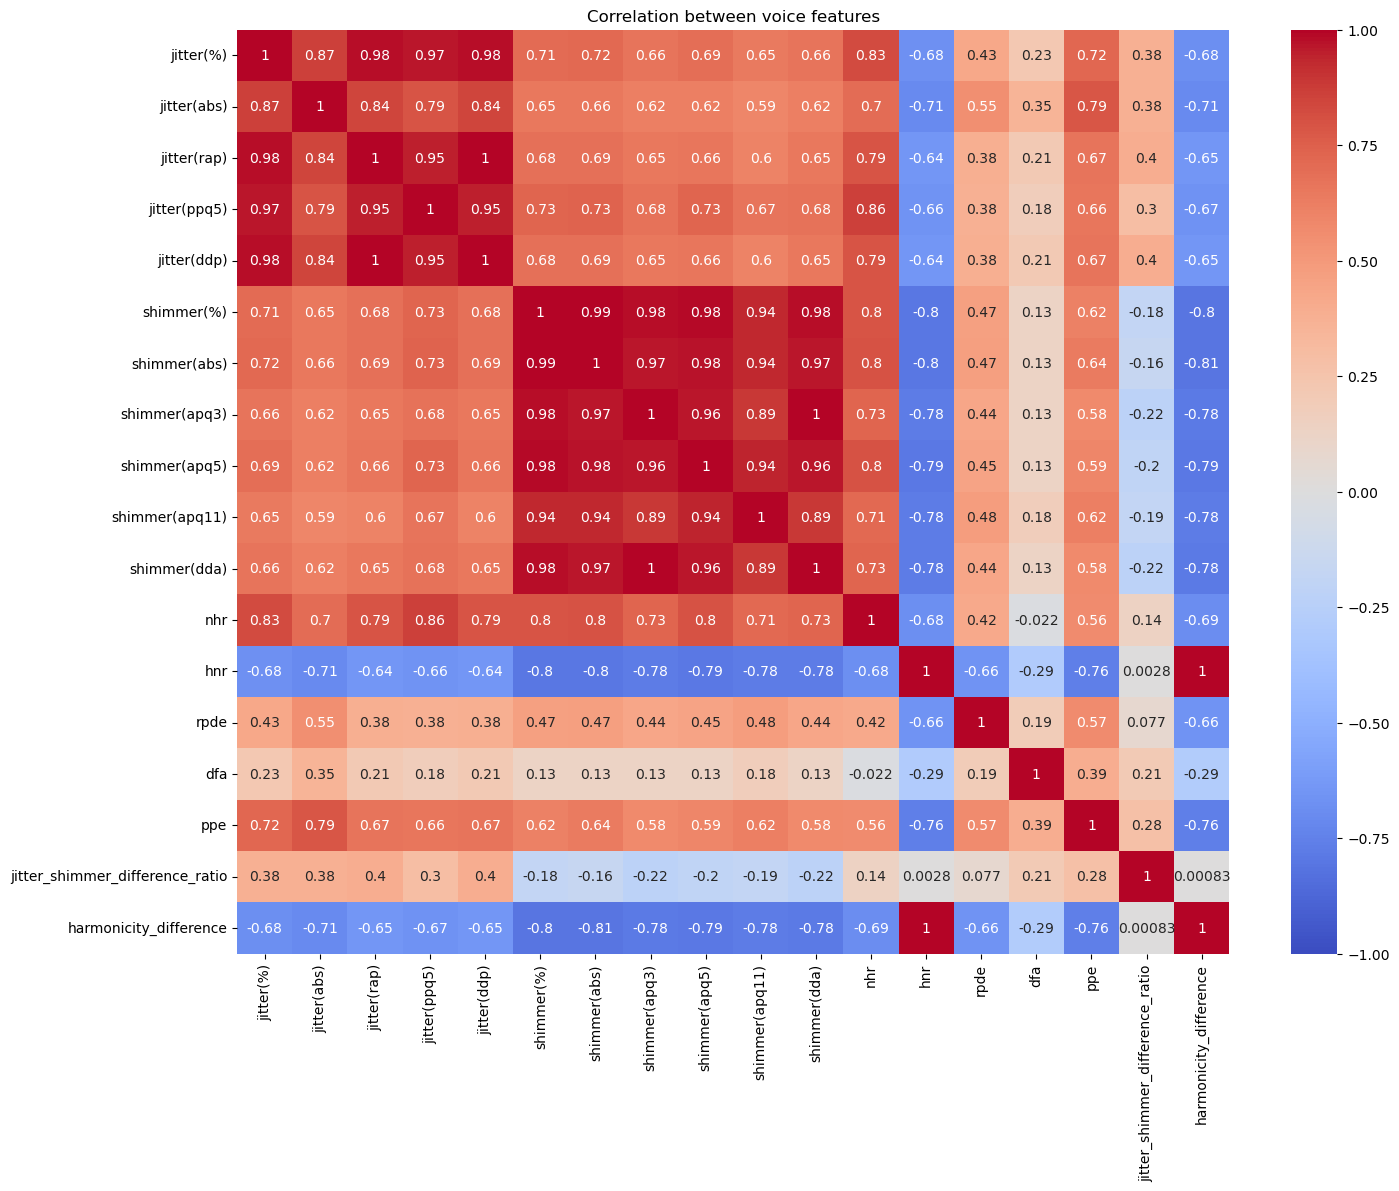

In [46]:
correlation_heatmap()

Multiple linear regression model for to predict motor_updrs

In [47]:
def multi_LS_motor():
    # Assuming df is already defined and populated
    df_multi = df.drop(['motor_updrs', 'total_updrs'], axis=1)

    # Splitting the data into train (80%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(df_multi, df['motor_updrs'], test_size=0.20, random_state=42)

    # Add constant to the training data
    X_train = sm.add_constant(X_train)

    # Build the model using training data
    model = sm.OLS(y_train, X_train).fit()

    # Add constant to the testing data
    X_test = sm.add_constant(X_test)

    # Predict using the test data
    pred_test = model.predict(X_test)

    # Print model summary
    print(model.summary())

In [48]:
# Baseline multiple linear regression model to predict motor_updrs
multi_LS_motor()

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     47.53
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          7.95e-171
Time:                        21:14:44   Log-Likelihood:                -16102.
No. Observations:                4700   AIC:                         3.225e+04
Df Residuals:                    4679   BIC:                         3.238e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Based on the heat map, shimmer attributes are highly correlated. Because shimmer(apq3) and shimmer(dda) have p-vlues = 0.780 and 0.782 > 0.05, we drop shimmer(apq3) and shimmer(dda).

In [49]:
# Drop unwanted columns
df_colli = df.drop(['motor_updrs', 'total_updrs', 'shimmer(apq3)', 'shimmer(dda)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(df_colli, df['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     52.67
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          5.05e-172
Time:                        21:14:44   Log-Likelihood:                -16104.
No. Observations:                4700   AIC:                         3.225e+04
Df Residuals:                    4681   BIC:                         3.237e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared doesn't increase, meaning that removing collinearity doesn't help improve the model.

Multiple linear regression model for to predict total_updrs

In [50]:
def multi_LS_total():
    # Build multiple linear regression model first
    df_multi = df.drop(['motor_updrs', 'total_updrs'], axis = 1)

    # Splitting the data into train (80%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(df_multi, df['total_updrs'], test_size=0.20, random_state=42)

    # Add constant to the training data
    X_train = sm.add_constant(X_train)

    # Build the model using training data
    model = sm.OLS(y_train, X_train).fit()

    # Add constant to the testing data
    X_test = sm.add_constant(X_test)

    # Predict using the test data
    pred_test = model.predict(X_test)

    # Print model summary
    print(model.summary())

In [51]:
# Baseline multiple linear regression model to predict total_updrs
multi_LS_total()

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     52.43
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          4.84e-188
Time:                        21:14:44   Log-Likelihood:                -17352.
No. Observations:                4700   AIC:                         3.475e+04
Df Residuals:                    4679   BIC:                         3.488e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [52]:
# Drop unwanted columns
df_colli = df.drop(['motor_updrs', 'total_updrs', 'shimmer(apq3)', 'shimmer(dda)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(df_colli, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     58.02
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          5.62e-189
Time:                        21:14:44   Log-Likelihood:                -17354.
No. Observations:                4700   AIC:                         3.475e+04
Df Residuals:                    4681   BIC:                         3.487e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared went down, meaning that removing collinearity doesn't help improve the model.

##### Log transformation

Multiple linear regression model for to predict motor_updrs

In [53]:
# Baseline multiple linear regression model to predict motor_updrs
multi_LS_motor()

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     47.53
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          7.95e-171
Time:                        21:14:44   Log-Likelihood:                -16102.
No. Observations:                4700   AIC:                         3.225e+04
Df Residuals:                    4679   BIC:                         3.238e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [54]:
# Define a new dataframe after log transformation
log_df = df.copy()

# Apply log transformation on variables shimmer(apq3) and shimmer(dda) because they have big p-values.
log_df["log_shimmer(apq3)"] = log_df["shimmer(apq3)"].apply(np.log)
log_df["log_shimmer(dda)"] = log_df["shimmer(dda)"].apply(np.log)
log_df["log_jitter(rap)"] = log_df["jitter(rap)"].apply(np.log)

# Drop the original variables shimmer(abs), shimmer(apq3) and shimmer(dda)
log_df = log_df.drop(["shimmer(apq3)", "shimmer(dda)", "jitter(rap)"], axis=1)

# Drop target variables 'motor_updrs' and 'total_updrs'
log_df_X = log_df.drop(['motor_updrs', 'total_updrs'], axis=1)

In [55]:
def log_df_motor():
    # Splitting the data into train (80%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(log_df_X, df['motor_updrs'], test_size=0.20, random_state=42)

    # Add constant to the training data
    X_train = sm.add_constant(X_train)

    # Build the model using training data
    model = sm.OLS(y_train, X_train).fit()

    # Add constant to the testing data
    X_test = sm.add_constant(X_test)

    # Predict using the test data
    pred_test = model.predict(X_test)

    # Print model summary
    print(model.summary())

In [56]:
log_df_motor()

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     49.24
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          7.54e-177
Time:                        21:14:44   Log-Likelihood:                -16088.
No. Observations:                4700   AIC:                         3.222e+04
Df Residuals:                    4679   BIC:                         3.235e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared went up from 0.165 to 0.170, meaning that log-transformation helps improve the model.

Multiple linear regression model for to predict total_updrs

In [57]:
# Baseline multiple linear regression model to predict total_updrs
multi_LS_total()

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     52.43
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          4.84e-188
Time:                        21:14:44   Log-Likelihood:                -17352.
No. Observations:                4700   AIC:                         3.475e+04
Df Residuals:                    4679   BIC:                         3.488e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [58]:
def log_df_total():
    # Splitting the data into train (80%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(log_df_X, df['total_updrs'], test_size=0.20, random_state=42)

    # Add constant to the training data
    X_train = sm.add_constant(X_train)

    # Build the model using training data
    model = sm.OLS(y_train, X_train).fit()

    # Add constant to the testing data
    X_test = sm.add_constant(X_test)

    # Predict using the test data
    pred_test = model.predict(X_test)

    # Print model summary
    print(model.summary())

In [59]:
log_df_total()

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     54.09
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          8.39e-194
Time:                        21:14:44   Log-Likelihood:                -17339.
No. Observations:                4700   AIC:                         3.472e+04
Df Residuals:                    4679   BIC:                         3.485e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared went up from 0.180 to 0.184, meaning that log-transformation helps improve the model.

#### Standardisation and Gaussian transformation

##### standardisation

Multiple Linear Regression for motor_updrs

In [60]:
# Baseline multiple linear regression model to predict motor_updrs
multi_LS_motor()

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     47.53
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          7.95e-171
Time:                        21:14:44   Log-Likelihood:                -16102.
No. Observations:                4700   AIC:                         3.225e+04
Df Residuals:                    4679   BIC:                         3.238e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [61]:
df_Stan = df.drop(['motor_updrs', 'total_updrs','sex'], axis = 1)

In [62]:
# Apply standardisation
scaler = StandardScaler()
std_df_Stan = scaler.fit_transform(df_Stan.values)

# Restore the column names of each explanatory variable
std_df_Stan_df = pd.DataFrame(std_df_Stan, index=df_Stan.index, columns=df_Stan.columns)

In [63]:
# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(std_df_Stan_df, df['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     48.69
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          4.00e-167
Time:                        21:14:44   Log-Likelihood:                -16113.
No. Observations:                4700   AIC:                         3.227e+04
Df Residuals:                    4680   BIC:                         3.240e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared went down (0.165 to 0.162), meaning that standardisation doesn't help improve the model.

Multiple Linear Regression for total_updrs

In [64]:
# Baseline multiple linear regression model to predict total_updrs
multi_LS_total()

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     52.43
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          4.84e-188
Time:                        21:14:44   Log-Likelihood:                -17352.
No. Observations:                4700   AIC:                         3.475e+04
Df Residuals:                    4679   BIC:                         3.488e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [65]:
# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(std_df_Stan_df, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     50.93
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          1.12e-174
Time:                        21:14:44   Log-Likelihood:                -17386.
No. Observations:                4700   AIC:                         3.481e+04
Df Residuals:                    4680   BIC:                         3.494e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared went down (0.180 to 0.168), meaning that standardisation doesn't help improve the model.

##### Gaussian Transformation

Multiple Linear Regression for motor_updrs

In [66]:
# log-transformation multiple linear regression model to predict motor_updrs
log_df_motor()

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     49.24
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          7.54e-177
Time:                        21:14:44   Log-Likelihood:                -16088.
No. Observations:                4700   AIC:                         3.222e+04
Df Residuals:                    4679   BIC:                         3.235e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Apply Gaussian transformation after log-transformation

In [67]:
df_Gauss = log_df.drop(['motor_updrs', 'total_updrs', 'sex'], axis = 1)

In [68]:
# Create a Yeo-Johnson transformer
scaler = PowerTransformer()

# Apply the transformer to make all explanatory variables more Gaussian-looking
std_df_Gauss = scaler.fit_transform(df_Gauss.values)

# Restore column names of explanatory variables
std_df_Gauss_df = pd.DataFrame(std_df_Gauss, index=df_Gauss.index, columns=df_Gauss.columns)

In [69]:
def log_Gauss_motor():
    # Splitting the data into train (80%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(std_df_Gauss_df, df['motor_updrs'], test_size=0.20, random_state=42)

    # Add constant to the training data
    X_train = sm.add_constant(X_train)

    # Build the model using training data
    model = sm.OLS(y_train, X_train).fit()

    # Add constant to the testing data
    X_test = sm.add_constant(X_test)

    # Predict using the test data
    pred_test = model.predict(X_test)

    # Print model summary
    print(model.summary())

In [70]:
# Multiple linear regression model applied log-transformation and Gauss-transformation to predict motor_updrs
log_Gauss_motor()

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     54.84
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          2.09e-196
Time:                        21:14:45   Log-Likelihood:                -16042.
No. Observations:                4700   AIC:                         3.213e+04
Df Residuals:                    4679   BIC:                         3.226e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared went up (0.170 to 0.186), meaning that Gaussian transformation helps improve the model.

Multiple Linear Regression for total_updrs

In [71]:
# log-transformation multiple linear regression model to predict total_updrs
log_df_total()

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     54.09
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          8.39e-194
Time:                        21:14:45   Log-Likelihood:                -17339.
No. Observations:                4700   AIC:                         3.472e+04
Df Residuals:                    4679   BIC:                         3.485e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [72]:
def log_Gauss_total():
    # Splitting the data into train (80%) and test (20%)
    X_train, X_test, y_train, y_test = train_test_split(std_df_Gauss_df, df['total_updrs'], test_size=0.20, random_state=42)

    # Add constant to the training data
    X_train = sm.add_constant(X_train)

    # Build the model using training data
    model = sm.OLS(y_train, X_train).fit()

    # Add constant to the testing data
    X_test = sm.add_constant(X_test)

    # Predict using the test data
    pred_test = model.predict(X_test)

    # Print model summary
    print(model.summary())

In [73]:
# Multiple linear regression model applied log-transformation and Gauss-transformation to predict total_updrs
log_Gauss_total()

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     55.36
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          3.27e-198
Time:                        21:14:45   Log-Likelihood:                -17328.
No. Observations:                4700   AIC:                         3.470e+04
Df Residuals:                    4679   BIC:                         3.483e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared went up (0.184 to 0.188), meaning that Gaussian transformation helps improve the model.

So far, models with a combination of log-transformation and Gaussian transformation gives the best performance.

#### Apply backward elimination for feature selection

##### for models to predict motor_updrs

In [74]:
# Multiple linear regression model applied log-transformation and Gauss-transformation to predict motor_updrs
log_Gauss_motor()

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     54.84
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          2.09e-196
Time:                        21:14:45   Log-Likelihood:                -16042.
No. Observations:                4700   AIC:                         3.213e+04
Df Residuals:                    4679   BIC:                         3.226e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Remove 'jitter_shimmer_difference_ratio' because it has the biggest p-value (0.606 > 0.05) and it's strongly correlated with jitter(ddp)

In [75]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_1 = std_df_Gauss_df.drop(['jitter_shimmer_difference_ratio'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_1, df['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     57.72
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          3.09e-197
Time:                        21:14:45   Log-Likelihood:                -16042.
No. Observations:                4700   AIC:                         3.212e+04
Df Residuals:                    4680   BIC:                         3.225e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     21

Adjusted R-squared went up (0.186 to 0.187). So, we keep removing the next variable.

Remove 'jitter(ddp)' because it has the biggest p-value (0.376 > 0.05) and it's strongly correlated with jitter(%)

In [76]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_2 = log_Gauss_1.drop(['jitter(ddp)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_2, df['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     60.89
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          5.74e-198
Time:                        21:14:45   Log-Likelihood:                -16043.
No. Observations:                4700   AIC:                         3.212e+04
Df Residuals:                    4681   BIC:                         3.225e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     21

Adjusted R-squared remains unchanged. So, we keep removing the next variable.

Remove 'log_jitter(rap)' because it has the biggest p-value (0.515 > 0.05).

In [77]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_3 = log_Gauss_2.drop(['log_jitter(rap)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_3, df['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     64.45
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          8.67e-199
Time:                        21:14:45   Log-Likelihood:                -16043.
No. Observations:                4700   AIC:                         3.212e+04
Df Residuals:                    4682   BIC:                         3.224e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     21

Adjusted R-squared remains unchanged. So, we keep removing the next variable.

Remove 'shimmer(abs)' because it has the biggest p-value (0.196 > 0.05) and it's strongly correlated with 'shimmer(apq5)'.

In [78]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_4 = log_Gauss_3.drop(['shimmer(abs)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_4, df['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     68.36
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          2.35e-199
Time:                        21:14:45   Log-Likelihood:                -16044.
No. Observations:                4700   AIC:                         3.212e+04
Df Residuals:                    4683   BIC:                         3.223e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     21

Adjusted R-squared remains unchanged. Now, all variables have become significant because their p-values < 0.05. So, we stop removing variables. This model should be the best model so far to predict motor_updrs with Adjusted R-squared = 0.187.

In [79]:
print("Predictors of the model to predict motor_updrs: \n\n", log_Gauss_4.columns.unique())

Predictors of the model to predict motor_updrs: 

 Index(['age', 'test_time', 'jitter(%)', 'jitter(abs)', 'jitter(ppq5)',
       'shimmer(%)', 'shimmer(apq5)', 'shimmer(apq11)', 'nhr', 'hnr', 'rpde',
       'dfa', 'ppe', 'harmonicity_difference', 'log_shimmer(apq3)',
       'log_shimmer(dda)'],
      dtype='object')


##### for models to predict total_updrs

In [80]:
# Multiple linear regression model applied log-transformation and Gauss-transformation to predict total_updrs
log_Gauss_total()

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     55.36
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          3.27e-198
Time:                        21:14:46   Log-Likelihood:                -17328.
No. Observations:                4700   AIC:                         3.470e+04
Df Residuals:                    4679   BIC:                         3.483e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Remove 'jitter(ddp)' because it has the biggest p-value (0.946 > 0.05) and it's strongly correlated with 'jitter(%)'.

In [81]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_5 = std_df_Gauss_df.drop(['jitter(ddp)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_5, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     58.29
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          4.23e-199
Time:                        21:14:46   Log-Likelihood:                -17328.
No. Observations:                4700   AIC:                         3.470e+04
Df Residuals:                    4680   BIC:                         3.483e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared remains unchanged. So, we keep removing the next variable.

Remove 'jitter(%)' because it has the biggest p-value (0.779 > 0.05) and it's strongly correlated with 'jitter(abs)'.

In [82]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_6 = log_Gauss_5.drop(['jitter(%)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_6, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     61.53
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          5.52e-200
Time:                        21:14:47   Log-Likelihood:                -17328.
No. Observations:                4700   AIC:                         3.469e+04
Df Residuals:                    4681   BIC:                         3.482e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared remains unchanged. So, we keep removing the next variable.

Remove 'shimmer(abs)' because it has the biggest p-value (0.506 > 0.05) and it's strongly correlated with 'shimmer(apq11)'.

In [83]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_7 = log_Gauss_6.drop(['shimmer(abs)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_7, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     65.13
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          8.37e-201
Time:                        21:14:47   Log-Likelihood:                -17328.
No. Observations:                4700   AIC:                         3.469e+04
Df Residuals:                    4682   BIC:                         3.481e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared remains unchanged. So, we keep removing the next variable.

Remove 'jitter(ppq5)' because it has the biggest p-value (0.327 > 0.05) and it's strongly correlated with 'jitter(abs)'.

In [84]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_8 = log_Gauss_7.drop(['jitter(ppq5)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_8, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     69.15
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          1.59e-201
Time:                        21:14:48   Log-Likelihood:                -17329.
No. Observations:                4700   AIC:                         3.469e+04
Df Residuals:                    4683   BIC:                         3.480e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared remains unchanged. So, we keep removing the next variable.

Remove 'shimmer(%)' because it has the biggest p-value (0.208 > 0.05) and it's strongly correlated with 'shimmer(apq11)'.

In [85]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_9 = log_Gauss_8.drop(['shimmer(%)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_9, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     73.64
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          3.98e-202
Time:                        21:14:49   Log-Likelihood:                -17330.
No. Observations:                4700   AIC:                         3.469e+04
Df Residuals:                    4684   BIC:                         3.479e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared remains unchanged. So, we keep removing the next variable.

Remove 'jitter(abs)' because it has the biggest p-value (0.078 > 0.05) and it's strongly correlated with 'jitter_shimmer_difference_ratio'.

In [86]:
# Remove 'jitter_shimmer_difference_ratio' from std_df_Gauss_df
log_Gauss_10 = log_Gauss_9.drop(['jitter(abs)'], axis = 1)

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_10, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     78.64
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          2.04e-202
Time:                        21:14:49   Log-Likelihood:                -17331.
No. Observations:                4700   AIC:                         3.469e+04
Df Residuals:                    4685   BIC:                         3.479e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Adjusted R-squared remains unchanged. Now, all variables have become significant because their p-values < 0.05. So, we stop removing variables. This model should be the best model so far to predict total_updrs with Adjusted R-squared = 0.188.

In [87]:
print("Predictors of the model to predict total_updrs: \n\n", log_Gauss_10.columns.unique())

Predictors of the model to predict total_updrs: 

 Index(['age', 'test_time', 'shimmer(apq5)', 'shimmer(apq11)', 'nhr', 'hnr',
       'rpde', 'dfa', 'ppe', 'jitter_shimmer_difference_ratio',
       'harmonicity_difference', 'log_shimmer(apq3)', 'log_shimmer(dda)',
       'log_jitter(rap)'],
      dtype='object')


##### Remove intercept to see if it improves the models

predictive model for motor_updrs

In [88]:
# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_4, df['motor_updrs'], test_size=0.20, random_state=42)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            motor_updrs   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.544
Date:                Tue, 03 Oct 2023   Prob (F-statistic):                    7.33e-18
Time:                        21:14:50   Log-Likelihood:                         -21313.
No. Observations:                4700   AIC:                                  4.266e+04
Df Residuals:                    4684   BIC:                                  4.276e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

Adjusted R-squared of the model went down to 0.022

predictive model for total_updrs

In [89]:
# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_10, df['total_updrs'], test_size=0.20, random_state=42)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            total_updrs   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              7.862
Date:                Tue, 03 Oct 2023   Prob (F-statistic):                    9.00e-17
Time:                        21:14:51   Log-Likelihood:                         -22754.
No. Observations:                4700   AIC:                                  4.554e+04
Df Residuals:                    4686   BIC:                                  4.563e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

Adjusted R-squared of the model went down to 0.02

Excluding the intercept from a regression model can introduce bias if the true relationship doesn't pass through the origin (for example age can't be 0), leading to systematically inaccurate predictions. Including the intercept allows the model to account for baseline effects not captured by predictors, ensuring a better fit and more interpretable results. So we should keep the intercept when building the models.

#### Apply 10-fold cross validation for the optimal models

Model to predict motor_updrs

In [90]:
def cross_validate_motor_model():
    # Prepare data
    X = log_Gauss_10
    y = df['motor_updrs']

    # Add constant to the data
    X = sm.add_constant(X)

    # Set up 10-fold cross validation
    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    # Initialize an empty list to store the Mean Squared Error (MSE) for each fold
    mse_list = []
    # Initialize an empty list to store the Adjusted R-squared for each fold
    adj_r_squared_list = []

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Build the model using training data
        model = sm.OLS(y_train, X_train).fit()

        # Predict using the test data
        pred_test = model.predict(X_test)

        # Calculate and store the MSE for this fold
        mse = mean_squared_error(y_test, pred_test)
        mse_list.append(mse)
        
        # Store the Adjusted R-squared for this fold
        adj_r_squared_list.append(model.rsquared_adj)

        # Optionally, print model summary for each fold
        # print(model.summary())

    # Calculate the average MSE across all 10 folds
    avg_mse = np.mean(mse_list)
    # Calculate the average Adjusted R-squared across all 10 folds
    avg_adj_r_squared = np.mean(adj_r_squared_list)

    # Print the average MSE
    print(f'Average Mean Squared Error across 10 folds: {avg_mse}')
    # Print the average Adjusted R-squared
    print(f'Average Adjusted R-squared across 10 folds: {avg_adj_r_squared}')

# Call the function
cross_validate_motor_model()

Average Mean Squared Error across 10 folds: 55.642715894238826
Average Adjusted R-squared across 10 folds: 0.1597399076373101


Adjusted R-squared went down from 0.187 to 0.1597.

Model to predict total_updrs

In [91]:
def cross_validate_total_model():
    # Prepare data
    X = log_Gauss_10
    y = df['total_updrs']

    # Add constant to the data
    X = sm.add_constant(X)

    # Set up 10-fold cross validation
    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    # Initialize an empty list to store the Mean Squared Error (MSE) for each fold
    mse_list = []
    # Initialize an empty list to store the Adjusted R-squared for each fold
    adj_r_squared_list = []

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Build the model using training data
        model = sm.OLS(y_train, X_train).fit()

        # Predict using the test data
        pred_test = model.predict(X_test)

        # Calculate and store the MSE for this fold
        mse = mean_squared_error(y_test, pred_test)
        mse_list.append(mse)
        
        # Store the Adjusted R-squared for this fold
        adj_r_squared_list.append(model.rsquared_adj)

        # Optionally, print model summary for each fold
        # print(model.summary())

    # Calculate the average MSE across all 10 folds
    avg_mse = np.mean(mse_list)
    # Calculate the average Adjusted R-squared across all 10 folds
    avg_adj_r_squared = np.mean(adj_r_squared_list)

    # Print the average MSE
    print(f'Average Mean Squared Error across 10 folds: {avg_mse}')
    # Print the average Adjusted R-squared
    print(f'Average Adjusted R-squared across 10 folds: {avg_adj_r_squared}')

# Call the function
cross_validate_total_model()

Average Mean Squared Error across 10 folds: 94.06525682624039
Average Adjusted R-squared across 10 folds: 0.18021399847917094


Adjusted R-squared went down from 0.188 to 0.1802

#### Apply hyperparameter optimisation

Multiple linear regression to predict 'motor_updrs'

In [92]:
# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_4, df['motor_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            motor_updrs   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     68.36
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          2.35e-199
Time:                        21:14:54   Log-Likelihood:                -16044.
No. Observations:                4700   AIC:                         3.212e+04
Df Residuals:                    4683   BIC:                         3.223e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     21

In [93]:
# Define the model and the range of hyperparameters
model = Ridge()
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # regularization strength
    'fit_intercept': [True, False]  # specifies if a constant should be added to the decision function
}

# Create a Grid Search object with 10-fold cross validation
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error')

X = std_df_Gauss_df
y = df['motor_updrs']

# Fit the model to the data
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Use the best model for predictions or further training
best_model = grid_search.best_estimator_

Best hyperparameters:  {'alpha': 100, 'fit_intercept': True}


In [94]:
# Initialize Ridge regression model with the best hyperparameters
ridge_model = Ridge(alpha=100, fit_intercept=True)

# Train the model using training data
ridge_model.fit(X_train, y_train)

# Predict using the test data
pred_test = ridge_model.predict(X_test)

# Evaluate the model performance, e.g., with RMSE
rmse = mean_squared_error(y_test, pred_test, squared=False)
print(f"Test RMSE: {rmse:.4f}")

# If you want to see the coefficients:
coefficients = ridge_model.coef_
print(f"Model Coefficients: {coefficients}")

# Calculate R-squared
r2_score = ridge_model.score(X_test, y_test)
print(f"R-squared: {r2_score:.4f}")

# Calculate Adjusted R-squared
n = X_test.shape[0]  # number of observations
p = X_test.shape[1] - 1  # number of predictors; subtract 1 for the intercept
adjusted_r2 = 1 - (1 - r2_score) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

Test RMSE: 7.4652
Model Coefficients: [ 0.          1.73588273  0.61044899  1.71457443 -2.50415998  0.91801134
  1.05478727 -1.02235091  2.18797675 -1.1481394  -1.19746935  0.34087985
 -1.72294     0.79736939 -1.22405916 -1.61209588 -1.58916089]
R-squared: 0.1269
Adjusted R-squared: 0.1148


Adjusted R-squared went down (0.187 to 0.1118), meaning that hyperparameter doesn't help improve the model.

Multiple linear regression to predict 'total_updrs'

In [95]:
# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(log_Gauss_10, df['total_updrs'], test_size=0.20, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     78.64
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          2.04e-202
Time:                        21:14:55   Log-Likelihood:                -17331.
No. Observations:                4700   AIC:                         3.469e+04
Df Residuals:                    4685   BIC:                         3.479e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [96]:
# Define the model and the range of hyperparameters
model = Ridge()
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # regularization strength
    'fit_intercept': [True, False]  # specifies if a constant should be added to the decision function
}

# Create a Grid Search object with 10-fold cross validation
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error')

X = std_df_Gauss_df
y = df['total_updrs']

# Fit the model to the data
grid_search.fit(X, y)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Use the best model for predictions or further training
best_model = grid_search.best_estimator_

Best hyperparameters:  {'alpha': 100, 'fit_intercept': True}


In [97]:
# Initialize Ridge regression model with the best hyperparameters
ridge_model = Ridge(alpha=100, fit_intercept=True)

# Train the model using training data
ridge_model.fit(X_train, y_train)

# Predict using the test data
pred_test = ridge_model.predict(X_test)

# Evaluate the model performance, e.g., with RMSE
rmse = mean_squared_error(y_test, pred_test, squared=False)
print(f"Test RMSE: {rmse:.4f}")

# If you want to see the coefficients:
coefficients = ridge_model.coef_
print(f"Model Coefficients: {coefficients}")

# Calculate R-squared
r2_score = ridge_model.score(X_test, y_test)
print(f"R-squared: {r2_score:.4f}")

# Calculate Adjusted R-squared
n = X_test.shape[0]  # number of observations
p = X_test.shape[1] - 1  # number of predictors; subtract 1 for the intercept
adjusted_r2 = 1 - (1 - r2_score) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2:.4f}")

Test RMSE: 9.7520
Model Coefficients: [ 0.          2.75710967  0.84394327 -0.30761786  2.07065261 -2.04904276
 -1.52841696  0.53601994 -2.53121046  0.95886799  0.12912404 -1.57964693
 -1.55261371 -1.50843043  1.13713412]
R-squared: 0.1418
Adjusted R-squared: 0.1314


Adjusted R-squared went down (0.188 to 0.1314), meaning that hyperparameter doesn't help improve the model.

#### Use another dataset to validate the performance of our predictive model

We use a dataset in a .txt file. The original study collected voice recordings from 20 individuals with Parkinson's disease and 20 without. Each of these participants contributed 26 voice samples, and these were analyzed for different acoustic characteristics using software called Praat.

Learn more about Praat software: https://www.fon.hum.uva.nl/praat/

###### Data dictionary

| Column | Measurement category                | Description                                                                                                        |
|:--------|:-----------------------------------|:-------------------------------------------------------------------------------------------------------------------|
| 1       | Subject identifier                | This number identifies a study subject                                                                             |
| 2       | Jitter                            | Jitter in %                                                                                                        |
| 3       | Jitter                            | Absolute jitter in microseconds                                                                                    |
| 4       | Jitter                            | Jitter as relative amplitude perturbation (r.a.p.)                                                                 |
| 5       | Jitter                            | Jitter as 5-point period perturbation quotient (p.p.q.5)                                                           |
| 6       | Jitter                            | Jitter as average absolute difference of differences between jitter cycles (d.d.p.)                                |
| 7       | Shimmer                           | Shimmer in %                                                                                                       |
| 8       | Shimmer                           | Absolute shimmer in decibels (dB)                                                                                  |
| 9       | Shimmer                           | Shimmer as 3-point amplitude perturbation quotient (a.p.q.3)                                                       |
| 10      | Shimmer                           | Shimmer as 5-point amplitude perturbation quotient (a.p.q.5)                                                       |
| 11      | Shimmer                           | Shimmer as 11-point amplitude perturbation quotient (a.p.q.11)                                                     |
| 12      | Shimmer                           | Shimmer as average absolute differences between consecutive differences between the amplitudes of shimmer cycles (d.d.a.) |
| 13      | Harmonicity                       | Autocorrelation between NHR and HNR                                                                                |
| 14      | Harmonicity                       | Noise-to-Harmonic ratio (NHR)                                                                                      |
| 15      | Harmonicity                       | Harmonic-to-Noise ratio (HNR)                                                                                      |
| 16      | Pitch                             | Median pitch                                                                                                       |
| 17      | Pitch                             | Mean pitch                                                                                                         |
| 18      | Pitch                             | Standard deviation of pitch                                                                                        |
| 19      | Pitch                             | Minimum pitch                                                                                                      |
| 20      | Pitch                             | Maximum pitch                                                                                                      |
| 21      | Pulse                             | Number of pulses                                                                                                   |
| 22      | Pulse                             | Number of periods                                                                                                  |
| 23      | Pulse                             | Mean period                                                                                                        |
| 24      | Pulse                             | Standard deviation of period                                                                                       |
| 25      | Voice                             | Fraction of unvoiced frames                                                                                        |
| 26      | Voice                             | Number of voice breaks                                                                                             |
| 27      | Voice                             | Degree of voice breaks                                                                                             |
| 28      | UPDRS                             | The Unified Parkinson’s Disease Rating Scale (UPDRS) score that is assigned to the subject by a physician via a medical examination to determine the severity and progression of Parkinson’s disease. |
| 29      | Jitter-shimmer-difference ratio  | Jitter(d.d.p) / Shimmer(d.d.a)                                                                                     |
| 30      | Harmonicity-to-Jitter ratio      | Harmonic-to-Noise ratio(HNR) / Jitter(%)                                                                           |
| 31      | Pitch range                       | Maximum pitch - Minimum pitch                                                                                      |
| 32      | Pulse-to-Pitch ratio              | Standard deviation of period / Standard deviation of pitch                                                         |
| 33      | PD indicator                      | Value “1” indicates a subject suffering from PD. Value “0” indicates a healthy subject.                            |

In [98]:
# Read data from the .txt file
df2 = pd.read_csv('new_po1_data.txt', header = None)
df2

0      1         2      3      4      5       6      7      8       9   \
0      1  1.488  0.000090  0.900  0.794  2.699   8.334  0.779  4.517   4.609   
1      1  0.728  0.000038  0.353  0.376  1.059   5.864  0.642  2.058   3.180   
2      1  1.220  0.000074  0.732  0.670  2.196   8.719  0.875  4.347   5.166   
3      1  2.502  0.000123  1.156  1.634  3.469  13.513  1.273  5.263   8.771   
4      1  3.509  0.000167  1.715  1.539  5.145   9.112  1.040  3.102   4.927   
...   ..    ...       ...    ...    ...    ...     ...    ...    ...     ...   
1035  40  5.127  0.000398  2.721  2.510  8.162   9.846  0.965  4.593   6.806   
1036  40  1.757  0.000133  0.808  0.690  2.425   7.571  0.740  2.720   3.927   
1037  40  2.912  0.000226  1.141  1.266  3.423  15.489  1.456  6.433  10.138   
1038  40  3.788  0.000275  1.786  1.484  5.359  15.702  1.367  6.374  11.094   
1039  40  1.809  0.000149  0.680  0.843  2.040   7.881  0.782  2.690   4.543   

      ...        23      24  25      26  27        28         29       30  \
0     ...  0.000416   0.000   0   0.000  23  0.199173   7.479839   45.347   
1     ...  0.000403   2.247   0   0.000  23  0.171498  23.905220   74.990   
2     ...  0.000474  10.656   1   0.178  23  0.168405  10.009836   64.997   
3     ...  0.000320   0.000   0   0.000  23  0.219710   4.549960   37.517   
4     ...  0.000380  18.182   1  13.318  23  0.552810   3.035908   42.341   
...   ...       ...     ...  ..     ...  ..       ...        ...      ...   
1035  ...  0.001066  24.194   2  15.113   1  0.592308   1.325922   62.446   
1036  ...  0.000430  46.053   1  25.792   1  0.297181   6.383608   22.307   
1037  ...  0.000881  20.000   1   4.574   1  0.177358   3.789492   53.720   
1038  ...  0.001714  16.667   3  19.575   1  0.280238   1.737856  361.315   
1039  ...  0.000566  18.182   1   3.387   1  0.252819   7.447208   29.402   

            31  32  
0     0.000040   1  
1     0.000027   1  
2     0.000037   1  
3     0.000029   1  
4     0.000033   1  
...        ...  ..  
1035  0.000074   0  
1036  0.000060   0  
1037  0.000065   0  
1038  0.000037   0  
1039  0.000070   0  

[1040 rows x 33 columns]

In [99]:
# Check the shape of the dataset
df2.shape

(1040, 33)

In [100]:
# Check if there's any missing values or abnormal data and check datatypes of all variables
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1040 non-null   int64  
 1   1       1040 non-null   float64
 2   2       1040 non-null   float64
 3   3       1040 non-null   float64
 4   4       1040 non-null   float64
 5   5       1040 non-null   float64
 6   6       1040 non-null   float64
 7   7       1040 non-null   float64
 8   8       1040 non-null   float64
 9   9       1040 non-null   float64
 10  10      1040 non-null   float64
 11  11      1040 non-null   float64
 12  12      1040 non-null   float64
 13  13      1040 non-null   float64
 14  14      1040 non-null   float64
 15  15      1040 non-null   float64
 16  16      1040 non-null   float64
 17  17      1040 non-null   float64
 18  18      1040 non-null   float64
 19  19      1040 non-null   float64
 20  20      1040 non-null   int64  
 21  21      1040 non-null   int64  
 22  

In [101]:
# Because the first half of the dataset is for people with Parkinson's disease, the second half is for healthy people,
# we just keep the first half to validate the prdictive model
# dataframe of the first part
df2 = df2[df2[df2.columns[-1]] == 1]
df2

0      1         2      3      4      5       6      7       8       9   \
0     1  1.488  0.000090  0.900  0.794  2.699   8.334  0.779   4.517   4.609   
1     1  0.728  0.000038  0.353  0.376  1.059   5.864  0.642   2.058   3.180   
2     1  1.220  0.000074  0.732  0.670  2.196   8.719  0.875   4.347   5.166   
3     1  2.502  0.000123  1.156  1.634  3.469  13.513  1.273   5.263   8.771   
4     1  3.509  0.000167  1.715  1.539  5.145   9.112  1.040   3.102   4.927   
..   ..    ...       ...    ...    ...    ...     ...    ...     ...     ...   
515  20  1.909  0.000103  0.786  0.577  2.357   8.885  0.833   4.256   5.460   
516  20  1.992  0.000118  0.911  0.866  2.733  19.904  1.713  11.212  10.396   
517  20  1.845  0.000100  1.073  1.096  3.219  11.451  1.052   5.815   6.652   
518  20  2.345  0.000127  0.937  1.173  2.811  12.952  1.167   5.976   8.343   
519  20  3.515  0.000201  1.618  2.088  4.855  10.881  1.013   5.124   7.445   

     ...        23      24  25      26  27        28         29      30  \
0    ...  0.000416   0.000   0   0.000  23  0.199173   7.479839  45.347   
1    ...  0.000403   2.247   0   0.000  23  0.171498  23.905220  74.990   
2    ...  0.000474  10.656   1   0.178  23  0.168405  10.009836  64.997   
3    ...  0.000320   0.000   0   0.000  23  0.219710   4.549960  37.517   
4    ...  0.000380  18.182   1  13.318  23  0.552810   3.035908  42.341   
..   ...       ...     ...  ..     ...  ..       ...        ...     ...   
515  ...  0.000366  62.295   1  35.053  46  0.184602   4.173913  41.378   
516  ...  0.000158  71.111   1  54.629  46  0.081250   1.892570  14.341   
517  ...  0.000238  19.512   0   0.000  46  0.184523   4.971816  39.570   
518  ...  0.000712  38.983   1  12.203  46  0.156785   2.819616  65.819   
519  ...  0.000510  32.258   1   3.547  46  0.315834   2.419061  58.620   

           31  32  
0    0.000040   1  
1    0.000027   1  
2    0.000037   1  
3    0.000029   1  
4    0.000033   1  
..        ...  ..  
515  0.000032   1  
516  0.000041   1  
517  0.000031   1  
518  0.000039   1  
519  0.000042   1  

[520 rows x 33 columns]

In [102]:
# Keep only the columns with specified indices
indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 27, 28]
df3 = df2.iloc[:, indices]

# Rename columns based on the provided list
column_names = [
    "jitter(%)", "jitter(abs)", "jitter(rap)", "jitter(ppq5)", "jitter(ddp)",
    "shimmer(%)", "shimmer(abs)", "shimmer(apq3)", "shimmer(apq5)", "shimmer(apq11)",
    "shimmer(dda)", "nhr", "hnr", "total_updrs", "jitter_shimmer_difference_ratio"
]
df3.columns = column_names
df3.head()

jitter(%)  jitter(abs)  jitter(rap)  jitter(ppq5)  jitter(ddp)  shimmer(%)  \
0      1.488     0.000090        0.900         0.794        2.699       8.334   
1      0.728     0.000038        0.353         0.376        1.059       5.864   
2      1.220     0.000074        0.732         0.670        2.196       8.719   
3      2.502     0.000123        1.156         1.634        3.469      13.513   
4      3.509     0.000167        1.715         1.539        5.145       9.112   

   shimmer(abs)  shimmer(apq3)  shimmer(apq5)  shimmer(apq11)  shimmer(dda)  \
0         0.779          4.517          4.609           6.802        13.551   
1         0.642          2.058          3.180           7.194         6.175   
2         0.875          4.347          5.166           7.548        13.040   
3         1.273          5.263          8.771          16.779        15.789   
4         1.040          3.102          4.927          12.823         9.307   

        nhr     hnr  total_updrs  jitter_shimmer_difference_ratio  
0  0.119116  11.130           23                         0.199173  
1  0.066758  17.403           23                         0.171498  
2  0.109983  12.212           23                         0.168405  
3  0.121982  11.384           23                         0.219710  
4  0.236831  10.653           23                         0.552810

In [103]:
df4 = df3.copy()
# Add log-transformed columns
df4['log_shimmer(apq3)'] = np.log(df4['shimmer(apq3)'])
df4['log_shimmer(dda)'] = np.log(df4['shimmer(dda)'])
df4['log_jitter(rap)'] = np.log(df4['jitter(rap)'])

# Drop specified columns
df4 = df4.drop(columns=['shimmer(apq3)', 'shimmer(dda)', 'jitter(rap)'])

# Rename columns based on the provided list
column_names_2 = [
    "jitter(%)", "jitter(abs)", "jitter(ppq5)", "jitter(ddp)",
    "shimmer(%)", "shimmer(abs)", "shimmer(apq5)", "shimmer(apq11)",
    "nhr", "hnr", "total_updrs", "jitter_shimmer_difference_ratio",
    "log_shimmer(apq3)", "log_shimmer(dda)", "log_jitter(rap)"
]
df3.columns = column_names_2

# Apply the Yeo-Johnson transformation
transformer = PowerTransformer(method='yeo-johnson', standardize=False)
df4_transformed = transformer.fit_transform(df4)

# Convert the result back to a DataFrame
df4 = pd.DataFrame(df4_transformed, columns=df4.columns)

df4.head()  # Display the transformed dataframe

jitter(%)  jitter(abs)  jitter(ppq5)  jitter(ddp)  shimmer(%)  \
0   0.967733     0.000079      0.522862     1.352104    4.259495   
1   0.566899     0.000036      0.300190     0.735514    3.338850   
2   0.840356     0.000067      0.464981     1.196563    4.392032   
3   1.361324     0.000103      0.807193     1.555046    5.871664   
4   1.663781     0.000133      0.781795     1.901227    4.524786   

   shimmer(abs)  shimmer(apq5)  shimmer(apq11)       nhr       hnr  \
0      0.766922       2.080176        2.870948  0.101197  3.751419   
1      0.633522       1.669814        2.964231  0.060771  4.708418   
2      0.860094       2.217815        3.045858  0.094544  3.937734   
3      1.243973       2.927743        4.642565  0.103252  3.796160   
4      1.019687       2.160010        4.052555  0.174480  3.665612   

   total_updrs  jitter_shimmer_difference_ratio  log_shimmer(apq3)  \
0      7.95414                         0.137438           2.423934   
1      7.95414                         0.123943           0.936998   
2      7.95414                         0.122350           2.340516   
3      7.95414                         0.146632           2.767155   
4      7.95414                         0.234977           1.654306   

   log_shimmer(dda)  log_jitter(rap)  
0          7.511008        -0.102840  
1          4.133003        -0.864871  
2          7.321619        -0.291748  
3          8.289287         0.149861  
4          5.767674         0.603387

In [104]:
# Define the independent variables and dependent variable
X = std_df_Gauss_df[['jitter(%)', 'jitter(abs)', 'jitter(ppq5)', 'jitter(ddp)',
          'shimmer(%)', 'shimmer(abs)', 'shimmer(apq5)', 'shimmer(apq11)',
          'nhr', 'hnr', 'jitter_shimmer_difference_ratio', 'log_shimmer(apq3)', 'log_shimmer(dda)', 'log_jitter(rap)']]

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, df['total_updrs'], test_size=0.30, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     22.80
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           2.73e-57
Time:                        21:14:58   Log-Likelihood:                -15442.
No. Observations:                4112   AIC:                         3.091e+04
Df Residuals:                    4097   BIC:                         3.101e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [105]:
X_new = df4[['jitter(%)', 'jitter(abs)', 'jitter(ppq5)', 'jitter(ddp)',
          'shimmer(%)', 'shimmer(abs)', 'shimmer(apq5)', 'shimmer(apq11)',
          'nhr', 'hnr', 'jitter_shimmer_difference_ratio', 'log_shimmer(apq3)', 'log_shimmer(dda)', 'log_jitter(rap)']]
X_new = sm.add_constant(X_new)

# Use the model built above to predict 'total_updrs' in the new dataset.
pred_new = model.predict(X_new)
actual_y = df4['total_updrs']

# Show the predicted values of (y) next to the actual values of (y)
df_pred = pd.DataFrame({"Actual": actual_y, "Predicted": pred_new})
print(df_pred)

        Actual    Predicted
0     7.954140  3197.371974
1     7.954140  2015.605643
2     7.954140  3130.711038
3     7.954140  3474.849030
4     7.954140  2596.962225
..         ...          ...
515  12.007234  3095.965093
516  12.007234  5041.215803
517  12.007234  3657.244379
518  12.007234  3711.534829
519  12.007234  3423.628306

[520 rows x 2 columns]


Test the model on the new additional dataset

In [106]:
# Calculate evaluation metrics
MAE = mean_absolute_error(actual_y, pred_new)
MSE = mean_squared_error(actual_y, pred_new)
RMSE = np.sqrt(MSE)
Normalized_RMSE = RMSE / (actual_y.max() - actual_y.min())

# Print out evaluation metrics
print(f"MAE: {MAE:.4f}")
print(f"MSE: {MSE:.4f}")
print(f"RMSE: {RMSE:.4f}")
print(f"Normalized RMSE: {Normalized_RMSE:.4f}")

MAE: 3479.5959
MSE: 12760627.7326
RMSE: 3572.2021
Normalized RMSE: 344.0144


Th errors showing big values indicates that the model performs very poorly on the dataset.

#### Use significant features in the additional dataset as predictors to build the model

In the first project, we analysed a dataset and concluded with a set of significant features that could be used to distinguish people with Parkinson's Disease and healthy people. There are a few same features that are in the dataset of the second project. 

They are: 'jitter(%)', 'jitter(abs)', 'jitter(ppq5)', 'jitter(ddp)', 'shimmer(apq11)', 'hnr', 'jitter_shimmer_difference_ratio'.

Now let's build a model based on these variables.

In [107]:
# Define the independent variables and dependent variable
X = df[['jitter(%)', 'jitter(abs)', 'jitter(ppq5)', 'jitter(ddp)', 'shimmer(apq11)', 'hnr', 'jitter_shimmer_difference_ratio']]

# Splitting the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, df['total_updrs'], test_size=0.30, random_state=42)

# Add constant to the training data
X_train = sm.add_constant(X_train)

# Build the model using training data
model = sm.OLS(y_train, X_train).fit()

# Add constant to the testing data
X_test = sm.add_constant(X_test)

# Predict using the test data
pred_test = model.predict(X_test)

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_updrs   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     25.25
Date:                Tue, 03 Oct 2023   Prob (F-statistic):           5.39e-34
Time:                        21:14:59   Log-Likelihood:                -15509.
No. Observations:                4112   AIC:                         3.103e+04
Df Residuals:                    4104   BIC:                         3.109e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Test the model on the new additional dataset

In [108]:
X_new = df4[['jitter(%)', 'jitter(abs)', 'jitter(ppq5)', 'jitter(ddp)', 'shimmer(apq11)', 'hnr', 'jitter_shimmer_difference_ratio']]
X_new = sm.add_constant(X_new)

# Use the model built above to predict 'total_updrs' in the new dataset.
pred_new = model.predict(X_new)
actual_y = df4['total_updrs']

# Show the predicted values of (y) next to the actual values of (y)
df_pred = pd.DataFrame({"Actual": actual_y, "Predicted": pred_new})
print(df_pred)

        Actual   Predicted
0     7.954140  259.505899
1     7.954140  223.646400
2     7.954140  229.991158
3     7.954140  390.490506
4     7.954140  608.129249
..         ...         ...
515  12.007234  551.187312
516  12.007234  462.634318
517  12.007234  286.263115
518  12.007234  483.518665
519  12.007234  491.029251

[520 rows x 2 columns]


In [109]:
# Calculate evaluation metrics
MAE = mean_absolute_error(actual_y, pred_new)
MSE = mean_squared_error(actual_y, pred_new)
RMSE = np.sqrt(MSE)
Normalized_RMSE = RMSE / (actual_y.max() - actual_y.min())

# Print out evaluation metrics
print(f"MAE: {MAE:.4f}")
print(f"MSE: {MSE:.4f}")
print(f"RMSE: {RMSE:.4f}")
print(f"Normalized RMSE: {Normalized_RMSE:.4f}")

MAE: 481.4370
MSE: 271143.0489
RMSE: 520.7140
Normalized RMSE: 50.1464


MAE, MSE, RMSE, Normalized RMSE went down, meaning that the model performed better when using only significant variables as predictors of the model. However, the errors are still very big, which indicates that the model performs very poorly on the dataset.